# Assignment 2

### Ferenc Huszár, Nic Lane and Neil Lawrence

### 23rd February 2021

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures.

There are 230 marks given in total for this second assessment ($\approx 70\%$ of the total of 330 marks for this course), broken into three groups:
* (A) 75 marks for the guided questions on Residual Networks
* (B) 75 marks for the guided questions on RNNs
* (C) 80 marks for a mini-project of your choice

You can choose whichever mini-project you want to attempt, we give you a range of options. If you would like to do more of these, that's fine, but will only mark one, whichever appears fist in your submitted notebook. These tasks are a bit more exploratoy, you don't have to go overboard on them. Equally, if you struggle to get them to work the way you wanted/expected, please document what you tried and what you learned.

# A: Residual Networks

In these questions we will work with residual networks (ResNets). In order to save time, we won't be training these models ourselves. Pytorch provides pre-*trained* weights for a range of commonly used models in the `torchvision` package, including ResNets of various depth. Most of the pretrained ResNets available are slightly improved versions of those proposed in 'Deep Residual Learning for Image Recognition' by [He et al (2015)](https://arxiv.org/pdf/1512.03385.pdf).

Note: you can request colab to run a GPU by going to Runtime -> Change runtime type. However, since we are only going to work with single images, it is unlikely this will buy you significant speedup.


## Setting up: Blas the border collie

To start, we will look at whether ResNets of different length can correctly classify my friend's dog Blas as a Border Collie.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://caballerojose.com/images/blas.jpg

--2021-03-14 00:23:16--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com (caballerojose.com)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to caballerojose.com (caballerojose.com)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas.jpg’

blas.jpg            100%[===================>] 216.48K  --.-KB/s    in 0.02s   

2021-03-14 00:23:16 (9.80 MB/s) - ‘blas.jpg’ saved [221678/221678]



### Loading an image

We will use the Python Imaging Library (PIL) to load the image. Colab then displays the image in-line if it is the output of the last line in the cell. Hello Blas!

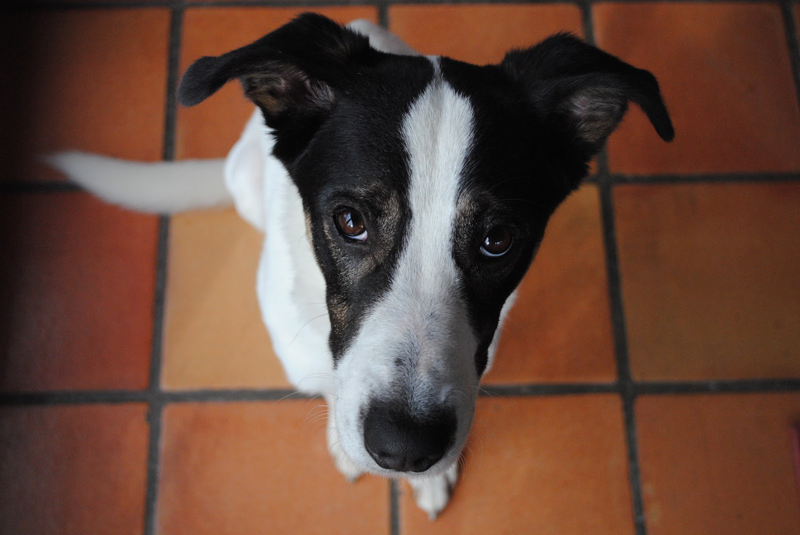

In [ ]:
from PIL import Image
img = Image.open('blas.jpg')
img.resize((800,535))

### Transformations

ConvNets expect input images to be of a certain size, otherwise the dimensions of the tensors within the network don't work out. We have to resize this image so it is of size $224\times 224$ as the network expects. Secondly, when training neural networks, we often normalise the inputs (substract the mean and divide by the standard deviation). As this model was trained on ImageNet, we have to use the mean and standard deviation from this dataset. Thankfully, we don't have to compute this, as it's included in the [pytorch documentation](https://pytorch.org/vision/0.8/models.html) (as well as elsewhere on the internet).

We will use `transforms` from the `torchvision` module to apply these transformations to the image. We also convert from `PIL.Image` to `torch.Tensor` in the process:


In [ ]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                )])

img_t = transform(img)

We can display the transformed image by converting it back to `PIL.Image`. We can see that the image was downsized, cropped to it's centre square region, and the colours are messed up due to normalization.

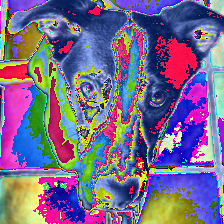

In [ ]:
transforms.ToPILImage()(img_t)

### Loading  the model

Now we are going to load the pre-trained 18-layer ResNet model from the `torchvision` library.

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Let's see how the model classifies Blas, the border collie. For this, we have to turn the image tensor into a minibatch of 1 example, which practically means adding an extra dimension to the tensor. This can be done using the `unsqueeze` function.

In [ ]:
x = img_t.unsqueeze(0)
y = resnet18(x)
print(x.size())
print(y.size())

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


The model's output is a vector of 1000 logits, one for each class in the ImageNet dataset. To interpret this, we have to know what the ImageNet classes are. Also, the logits themselves are less human-readable, so we are going to turn them into probabilities using a `softmax` function. This helper function below will do this for us.

In [ ]:
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)

def top_5_classes(y, class_names=None):
    if class_names == None:
        imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
        response = requests.get(imagenet_labels_url)
        class_names = json.loads(response.text)
    p = softmax(y[0,:], dim=0)
    values, indices = p.topk(5)
    return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

In [ ]:
top_5_classes(y)

[('bucket', 0.007806162),
 ('plunger', 0.007172808),
 ('hook', 0.0070160483),
 ('waste container', 0.00548113),
 ('water bottle', 0.0054325894)]

Oops, the model doesn't seem to recognise Blas. It thinks Blas is a bucket, plunger or hook. This is because in order to use the pretrained models in pytorch, we have to set them to evaluation mode. When training deep neural networks, sometimes the networks work differently at training and test time. For example, when using a technique called dropout, random units in the network may be dropped at training time, but at test time, all units are used and their output is scaled. Similarly, when using batch normalisation, the network works differently in training time and at test time. To set models to evaluation mode we can use the `eval` function.

In [ ]:
resnet18.eval()
y = resnet18(x)
top_5_classes(y)

[('Staffordshire Bull Terrier', 0.18194425),
 ('Cardigan Welsh Corgi', 0.14102171),
 ('American Staffordshire Terrier', 0.12816133),
 ('Basenji', 0.09343243),
 ('Whippet', 0.09127136)]

OK, getting there. At least the model now recognises Blas as a dog, but misses the specific breed. The correct class would be a Border Collie.

## Question A.1: Trying different pretrained networks

Now try different models from `torchvision` and see which ones can classify Blas correctly. In particular, check out deeper versions of ResNets. Use the [documentation](https://pytorch.org/vision/0.8/models.html) to find out what other networks are available. Use the code blocks below, and the text field to summarise what you found. (For full marks, try multiple ResNets, and at least two different non-ResNets).

*10 marks*

### Answer A.1

*Please use this cell to summarise which networks you tried.*

For this question, I tried ResNets with 50, 101, and 152 layers, and variations of ResNets, including aggregated ResNets (ResNeXts) and wide ResNets. I also tried non-ResNets such as AlexNet, VGG (with and without batch normalisation), and GoogLeNet. 

Findings:

* ResNets perform generally better on this image than non-ResNets;
* Deeper ResNets perform generally better on this image than shallower ResNets, given the same type of ResNet;
* ResNeXt-50 performs better than ResNet-50, but ResNeXt-100 misclassifies Blas as a Cardigan Welsh Corgi;
* Wide ResNets performs generally better on this image than standard ResNets, given the same number of layers;
* VGG-19 with batch normalisation performs better on this image than without batch normalisation, judging from the predicted probability they produce for Border Collie.

In [ ]:
# please add code for question A.1 here. You may add further code cells below.

# ResNet-50
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
y = resnet50(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


[('Border Collie', 0.26453617),
 ('collie', 0.18160026),
 ('Cardigan Welsh Corgi', 0.17722456),
 ('Whippet', 0.12113578),
 ('Australian Kelpie', 0.05963931)]

In [ ]:
# ResNet-101
resnet101 = models.resnet101(pretrained=True)
resnet101.eval()
y = resnet101(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


[('Border Collie', 0.33726576),
 ('Basenji', 0.23494701),
 ('Cardigan Welsh Corgi', 0.17642708),
 ('collie', 0.06710181),
 ('Boston Terrier', 0.027117426)]

In [ ]:
# ResNet-152
resnet152 = models.resnet152(pretrained=True)
resnet152.eval()
y = resnet152(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


[('Border Collie', 0.36757603),
 ('collie', 0.29964197),
 ('Whippet', 0.1255131),
 ('Cardigan Welsh Corgi', 0.07364116),
 ('Australian Kelpie', 0.033829622)]

In [ ]:
# ResNeXt-50-32x4d
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
resnext50_32x4d.eval()
y = resnext50_32x4d(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


[('Border Collie', 0.35402396),
 ('Cardigan Welsh Corgi', 0.3112186),
 ('Australian Kelpie', 0.17536809),
 ('Basenji', 0.06990592),
 ('collie', 0.051389948)]

In [ ]:
# ResNeXt-101-32x8d
resnext101_32x8d = models.resnext101_32x8d(pretrained=True)
resnext101_32x8d.eval()
y = resnext101_32x8d(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


[('Cardigan Welsh Corgi', 0.9398499),
 ('Border Collie', 0.020422004),
 ('Whippet', 0.0121265175),
 ('Basenji', 0.006576934),
 ('collie', 0.0045894827)]

In [ ]:
# Wide ResNet-50
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
wide_resnet50_2.eval()
y = wide_resnet50_2(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


[('Border Collie', 0.40921822),
 ('Cardigan Welsh Corgi', 0.1260889),
 ('Whippet', 0.11586778),
 ('collie', 0.090853944),
 ('Australian Kelpie', 0.061433244)]

In [ ]:
# Wide ResNet-101
wide_resnet101_2 = models.wide_resnet101_2(pretrained=True)
wide_resnet101_2.eval()
y = wide_resnet101_2(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


[('Border Collie', 0.3624439),
 ('Whippet', 0.2292052),
 ('collie', 0.117414854),
 ('Cardigan Welsh Corgi', 0.09347275),
 ('Australian Kelpie', 0.043870665)]

In [ ]:
# AlexNet
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
y = alexnet(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


[('Whippet', 0.3544034),
 ('Basenji', 0.23355283),
 ('toy terrier', 0.12923832),
 ('Boston Terrier', 0.11565431),
 ('Italian Greyhound', 0.07830699)]

In [ ]:
# VGG-19
vgg19 = models.vgg19(pretrained=True)
vgg19.eval()
y = vgg19(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


[('Cardigan Welsh Corgi', 0.67670065),
 ('Basenji', 0.12864792),
 ('Whippet', 0.117506735),
 ('Border Collie', 0.03454853),
 ('collie', 0.014183084)]

In [ ]:
# VGG-19 with batch normalization
vgg19_bn = models.vgg19_bn(pretrained=True)
vgg19_bn.eval()
y = vgg19_bn(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


[('Cardigan Welsh Corgi', 0.66506183),
 ('Border Collie', 0.103578575),
 ('Basenji', 0.05064933),
 ('Australian Kelpie', 0.035239894),
 ('toy terrier', 0.02676743)]

In [ ]:
# GoogLeNet
googlenet = models.googlenet(pretrained=True)
googlenet.eval()
y = googlenet(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


[('Whippet', 0.28620014),
 ('Great Dane', 0.11929965),
 ('American Staffordshire Terrier', 0.06753151),
 ('Staffordshire Bull Terrier', 0.050844464),
 ('Cardigan Welsh Corgi', 0.03912127)]

## Inspecting and modifying networks

For the next question, you will need to modify the pre-trained networks, and you will need to look inside them. Below, we share a few things that will help you learn how models work. First, let's look at what the `resnet18` architecture looks like and how that architecture is represented in pytorch. You can print the model to see a text description of it:

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, modules are listed from top to bottom in order of how they are executed. In a pytorch ResNet, residual blocks are organised into `layers`, each of which contain sequences of residual blocks. You will notice that:
* the number of channels keeps doubling at each layer, in this case from 128 -> 256 -> 512.
* at the same time, the figure size is halved with each layer. The image size is halved by `MaxPool2d` layers as well as strided convolutions where the stride is `2`.
* a `resnet18` is built out of `BasicBlock` building blocks, which are the simple residual block proposed by [He et al, (2015)](https://arxiv.org/abs/1512.03385) which I showed in the lecture. Deeper ResNets, such as `resnet50` use a more complicated `Bottleneck` component instead.
* in pytorch, the linear and nonlinear parts of a layer are separate, i.e. the convolution and subsequent ReLU activation are handled as separate layers.

To access the second convolution layer from the second residual block at the third layer, you can write the following:

In [ ]:
resnet18.layer3[1].conv2

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

And you can access parameters of layers like so.

In [ ]:
resnet18.conv1.weight.size()

torch.Size([64, 3, 7, 7])

We can visualise the convolution kernels on the first layer using the code below. In addition to showing how to access weights, you may find some of this code useful as an example of using the `matplotlib.pylab` package for plotting.

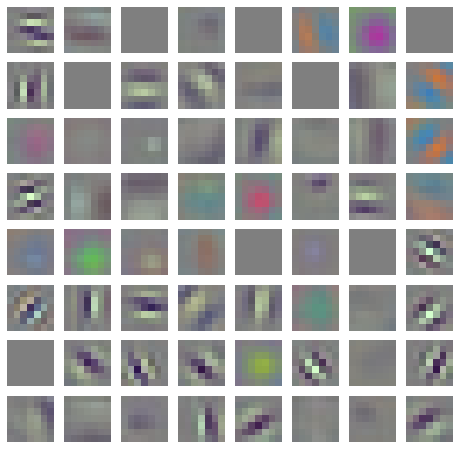

In [ ]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (8,8))

weights = resnet18.conv1.weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
    plt.subplot(8, 8, i+1)
    # we move the colour channel axis to the end, this is where imshow expects it
    plt.imshow(np.moveaxis(w, 0, -1))
    plt.axis('off')

In pytorch, you can inspect what each layer of the network does by using forward hooks. A forward hook is a python function that gets called whenever the layer is evaluated (i.e. data is passed through the layer). The forward hook function receives both the input and the output of the module. In pytorch, you can add a forward hook using the register_forward_hook function. 

For example, in the code below, I attach a hook to a layer, which simply prints something out. Instead of attaching the hook to the resnet18, I first create a `deepcopy` of the model, so the hook gets attached to the copy, but not to the `resnet18` model which I may use later.

In [ ]:
import copy

def useless_hook(module, input, output):
  print('The hook was called.')

model = copy.deepcopy(resnet18)
model.layer3[1].conv2.register_forward_hook(useless_hook)
y = model(x)
y = model(x)

The hook was called.
The hook was called.


## Question A.2: Inspecting layers in neural networks

This question has a subtasks:
1. print the number of parameters in each of the operations/layers of the `ResNet18`, and count how many there are in total.
1. print the *shape of the output tensor* of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. *Tip:* you can use a forward hook.
1. Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. *Tip:* you can use a forward for this here, too.
1. Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the shape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

*15 marks*

### Answer A.2

*please provide your answers in code cells below (you may use multiple code cells).*

#### Answer A.2.1

Firstly, I used the package `pytorch-model-summary` to print a table of the number of parameters in each layer, then I reproduced the table with my own code, using forward hooks, and got consistent results.

In [ ]:
!pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

model = copy.deepcopy(resnet18)
print(summary(model, torch.zeros(x.size()), show_input=False))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 112, 112]           9,408           9,408
          BatchNorm2d-2     [1, 64, 112, 112]             128             128
                 ReLU-3     [1, 64, 112, 112]               0               0
            MaxPool2d-4       [1, 64, 56, 56]               0               0
           BasicBlock-5       [1, 64, 56, 56]          73,984          73,984
           BasicBlock-6       [1, 64, 56, 56]          73,984          73,984
           BasicBlock-7      [1, 128, 28, 28]         230,144         230,144
           BasicBlock-8      [1, 128, 28, 28]         295,424         295,424
           BasicBlock-9      [1, 256, 14, 14]         919,040         919,040
          BasicBlock-10      [1, 256, 14, 14]       1,180,672       1,180,672
          BasicBlock-11        [1, 512, 7, 7]       3,673,088  

In [ ]:
layers_count = 0
total_params = 0
total_trainable_params = 0


def get_layer_name(layer):
    global layers_count

    layers_count += 1
    return layer.__class__.__name__ + '-' + str(layers_count)


def count_parameters(layer):
    global total_params, total_trainable_params

    param_count = 0
    trainable_param_count = 0
    for name, param in layer.named_parameters():
        param_count += param.numel()
        total_params += param.numel()
        if param.requires_grad: 
            trainable_param_count += param.numel()
            total_trainable_params += param.numel()

    return param_count, trainable_param_count


def print_layer_properties(layer, input, output):
    layer_name = get_layer_name(layer)
    output_size = list(output.size())
    param_count, trainable_param_count = count_parameters(layer)
    print("{:>23}{:>20}{:>16,d}{:>16,d}".format(layer_name, str(output_size), param_count, trainable_param_count))


model = copy.deepcopy(resnet18)

for name, layer in model.named_children():
    if layer.__class__.__name__ == 'Sequential':
        for sub_name, sub_layer in layer.named_children():
            sub_layer.register_forward_hook(print_layer_properties)
    else:
        layer.register_forward_hook(print_layer_properties)

print("----------------------------------------------------------------------------")
print("           Layer (type)        Output Shape         Param #     Tr. Param # ")
print("============================================================================")

y = model(x)

print("============================================================================")
print(f"Total Params: {total_params:,}")
print(f"Trainable Params: {total_trainable_params:,}")
print(f"Non-trainable Params: {(total_params - total_trainable_params):,}")
print("----------------------------------------------------------------------------")

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param # 
               Conv2d-1   [1, 64, 112, 112]           9,408           9,408
          BatchNorm2d-2   [1, 64, 112, 112]             128             128
                 ReLU-3   [1, 64, 112, 112]               0               0
            MaxPool2d-4     [1, 64, 56, 56]               0               0
           BasicBlock-5     [1, 64, 56, 56]          73,984          73,984
           BasicBlock-6     [1, 64, 56, 56]          73,984          73,984
           BasicBlock-7    [1, 128, 28, 28]         230,144         230,144
           BasicBlock-8    [1, 128, 28, 28]         295,424         295,424
           BasicBlock-9    [1, 256, 14, 14]         919,040         919,040
          BasicBlock-10    [1, 256, 14, 14]       1,180,672       1,180,672
          BasicBlock-11      [1, 512, 7, 7]       3,673,088       3,673,088
          

#### Answer A.2.2

In [ ]:
layers_count = 4

def print_conv2_output_shape(layer, input, output):
    global layers_count
    layers_count += 1
    layer_name = 'BasicBlock-' + str(layers_count)
    output_size = list(output.size())
    print("{:>16}{:>21}".format(layer_name, str(output_size)))

model = copy.deepcopy(resnet18)

for name, layer in model.named_children():
    if layer.__class__.__name__ == 'Sequential':
        for _, basic_block in layer.named_children():
            basic_block.conv2.register_forward_hook(print_conv2_output_shape)

print("--------------------------------------")
print("    Layer (type)   Conv2 Output Shape ")
print("======================================")

y = model(x)

print("--------------------------------------")

--------------------------------------
    Layer (type)   Conv2 Output Shape 
    BasicBlock-5      [1, 64, 56, 56]
    BasicBlock-6      [1, 64, 56, 56]
    BasicBlock-7     [1, 128, 28, 28]
    BasicBlock-8     [1, 128, 28, 28]
    BasicBlock-9     [1, 256, 14, 14]
   BasicBlock-10     [1, 256, 14, 14]
   BasicBlock-11       [1, 512, 7, 7]
   BasicBlock-12       [1, 512, 7, 7]
--------------------------------------


Summary: the shape of the output tensor of the `conv2` layer within each `BasicBlock` is the same as the shape of the output tensor of the entire `BasicBlock`.

#### Answer A.2.3

I extracted and plotted the activations on `layer3`. 

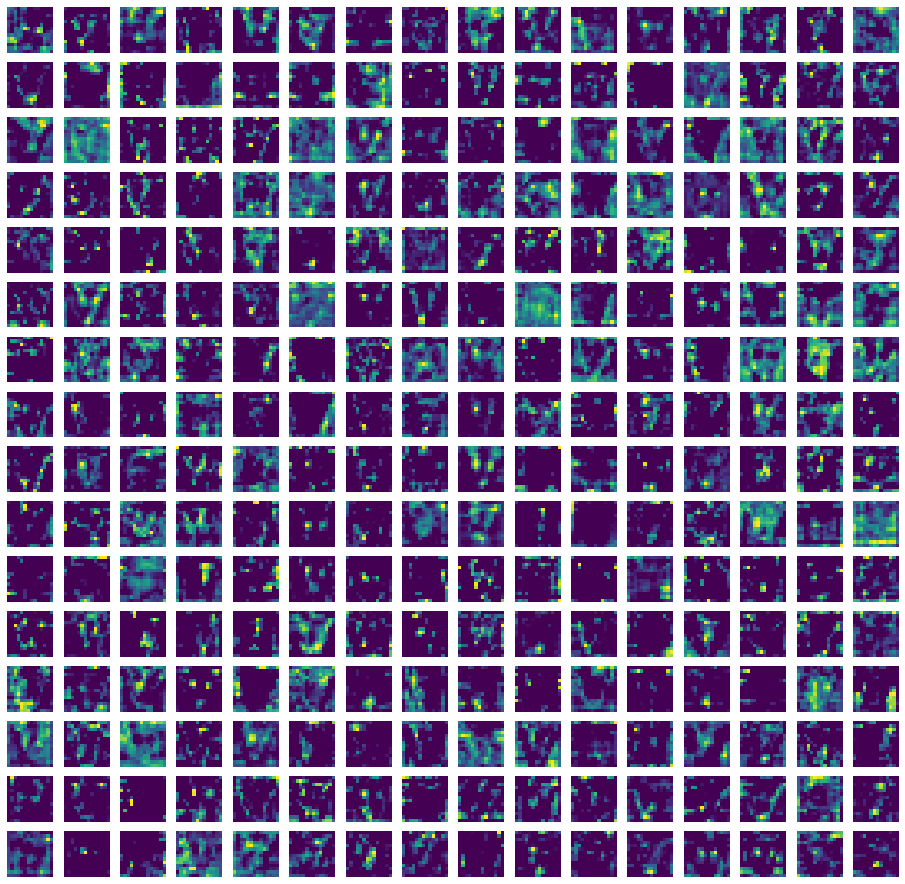

In [ ]:
def plot_activations(self, input, output):
    f = plt.figure(figsize=(16, 16))

    weights = output.detach().numpy()
    weights = weights / (np.abs(weights).max()) / 2 + 0.5

    for i, w in enumerate(np.moveaxis(weights, 1, 0)):
        plt.subplot(16, 16, i + 1)
        plt.imshow(w[0])
        plt.axis('off')

model = copy.deepcopy(resnet18)
model.layer3.register_forward_hook(plot_activations)
y = model(x)

Summary: compared to the visualisations of the activations of the first layer as shown in the previous example, which detects only edges and spots, the activations of this later layer shows more integrated patterns.

#### Answer A.2.4

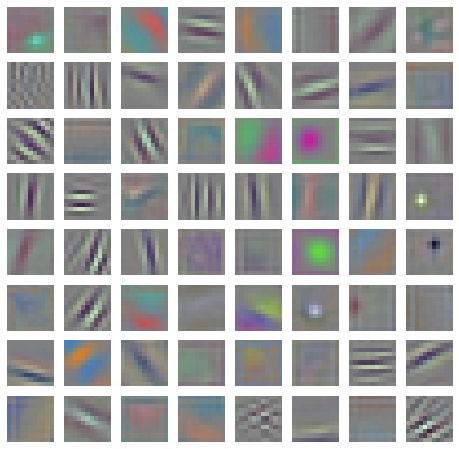

In [ ]:
# Weights in the first convolution layer of a pretrained AlexNet
f = plt.figure(figsize=(8, 8))

weights = alexnet.features[0].weight.detach().numpy()
weights = weights / (np.abs(weights).max()) / 2 + 0.5

for i, w in enumerate(weights):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.moveaxis(w, 0, -1))
    plt.axis('off')

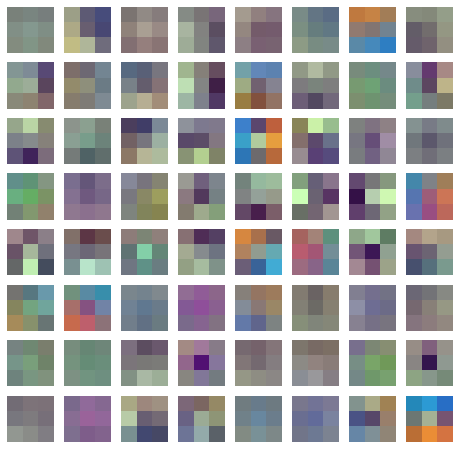

In [ ]:
# Weights in the first convolution layer of a pretrained VGG-19
f = plt.figure(figsize=(8, 8))

weights = vgg19.features[0].weight.detach().numpy()
weights = weights / (np.abs(weights).max()) / 2 + 0.5

for i, w in enumerate(weights):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.moveaxis(w, 0, -1))
    plt.axis('off')

Summary: the visualisations of the kernels of the first convolutional layer of AlexNet shows the clearest edge and spot patterns, followed by ResNet, and since the kernels of the first layer of VGG-19 is only 3x3, they hardly show any notable pattern. 

## Editing models

Models can be edited rather flexibly in pytorch. Underlying a pytorch `Module` are python `OrderedDict` objects. These are ordered lists of key-value pairs. Each submodule and each parameter has a name, which is the key. Members of the dictionay can be accessed as attributes of the `Module`. Adding a new parameter or layer to a module will add a new key-value pair to this dictionary.

Let's try adding a new operation to our resnet18, which converts the logits to probabilities. We will do this by replacing the final operation by a `Sequential` module, which chains multiple operations together.

In [ ]:
from torch.nn import Softmax, Sequential

model = copy.deepcopy(resnet18)
model.fc = Sequential(
    model.fc,
    Softmax(dim=1)
)

In [ ]:
#let's see what the model looks like now
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's check the model still works and that it outputs a vector of probabilities which therefore sums to one.

In [ ]:
y = model(x)
print(y.sum())

tensor(1.0000, grad_fn=<SumBackward0>)


We can also replace existing layers with other layers. Here, for example, I replace the first convolution layer with a randomly initialized one of the same dimensions. We can check what effect this has on the classification of Blas:

In [ ]:
from torch.nn import Conv2d

model = copy.deepcopy(resnet18)
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.eval()
y = model(x)
top_5_classes(y)

[('window shade', 0.121169105),
 ('shower curtain', 0.11750986),
 ('Windsor tie', 0.05676737),
 ('window screen', 0.04651613),
 ('maze', 0.030177575)]

Or, if we replace the convolutional layer by the convolutions from the VGG19 network, followed by a MaxPooling, to account for the difference in stride, the network becomes pretty certain that Blas is, in fact, spider web, or possibly a type of spider.

In [ ]:
from torch.nn import MaxPool2d

vgg19 = models.vgg19(pretrained=True)

model = copy.deepcopy(resnet18)
model.conv1 = Sequential(
    vgg19.features[0],
    MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
model.eval()
y = model(x)
top_5_classes(y)

[('spider web', 0.90654707),
 ('barn spider', 0.038704745),
 ('European garden spider', 0.013483303),
 ('window screen', 0.011457818),
 ('wolf spider', 0.0041355453)]

## Question A.3: Dropping layers in ResNet15

This question is composed of several tasks:
1. Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. 
1. Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit more involved than the previous one).
1. Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.
* You can solve this task using a few lines of code only.

*15 marks*

### Answers A.3

*Please provide your answer in the code blocks below.*

In [ ]:
#1. dropping layer4 second block
model = copy.deepcopy(resnet18)
model.layer4 = model.layer4[0]
model.eval()
y = model(x)
top_5_classes(y)

[('Italian Greyhound', 0.0016954435),
 ('Boston Terrier', 0.0016745133),
 ('Basenji', 0.0016514725),
 ('space heater', 0.0016252267),
 ('Cardigan Welsh Corgi', 0.0015921455)]

In [ ]:
#2. dropping layer4 first block
model = copy.deepcopy(resnet18)

for name, layer in model.layer4[0].named_children():
    if layer.__class__.__name__ == 'Sequential':
        layer = None
    elif layer.__class__.__name__ == 'Conv2d':
        layer.weight.data.fill_(0.)
    elif layer.__class__.__name__ == 'BatchNorm2d':
        layer.weight.data.fill_(0.)
        layer.bias.data.fill_(0.)

model.eval()
y = model(x)
top_5_classes(y)

[('Basenji', 0.11985234),
 ('Cardigan Welsh Corgi', 0.07544409),
 ('Boston Terrier', 0.07537138),
 ('Treeing Walker Coonhound', 0.06430222),
 ('Whippet', 0.061824508)]

In [ ]:
#3. dropping layer2 first block
model = copy.deepcopy(resnet18)

for name, layer in model.layer2[0].named_children():
    if layer.__class__.__name__ == 'Sequential':
        layer = None
    elif layer.__class__.__name__ == 'Conv2d':
        layer.weight.data.fill_(0.)
    elif layer.__class__.__name__ == 'BatchNorm2d':
        layer.weight.data.fill_(0.)
        layer.bias.data.fill_(0.)

model.eval()
y = model(x)
top_5_classes(y)

[('doormat', 0.21820898),
 ('tennis ball', 0.05690365),
 ('maze', 0.032566976),
 ('wool', 0.018873638),
 ('baseball', 0.013284063)]

Summary:

* Deleting any layer from the original pretrained ResNet-18 reduces its accuracy;
* Deleting later layers from ResNet-18 gives a less negative effect on its accuracy than deleting earlier layers: the perturbed ResNet-18 with a `BasicBlock` from `layer4` deleted can still recognise Blas as a dog, but the perturbed ResNet-18 with a `BasicBlock` from `layer2` deleted totally fails this task.

## A convenience function: flattening ResNets

Residual blocks in pytorch ResNets are organised into 4 layers. I found this rather cumbersome for the next exercise we are going to do. In order to make ResNets easier to work with I created the convenience function below which can *flatten* the layer hierarchy of pytorch resnet models, merging the 4 layers into one, called `residual_blocks`. After flattening, instead of accessing `model.layer1[0]` you can do `model.residual_blocks[0]`.

In [ ]:
from torch import nn
from collections import OrderedDict

def flatten_resnet(resnet_model):
    """
    Takes a pytorch resnet model and returns a copy of the same model in a 
    flattened format, where the residulal blocks are not divided into four layers
    but are instead all in a residual blocks component.
    """
    model = copy.deepcopy(resnet_model)
    residual_blocks = nn.Sequential(*model.layer1,
                                    *model.layer2,
                                    *model.layer3,
                                    *model.layer4)
    return nn.Sequential(OrderedDict([
        ('conv1', model.conv1),
        ('bn1', model.bn1),
        ('relu', model.relu),
        ('maxpool', model.maxpool),
        ('residual_blocks', residual_blocks),
        ('avgpool', model.avgpool),
        ('flatten', nn.Flatten()),
        ('fc', model.fc)
    ]))

## Question A.4: Dropping layers in ResNet50

Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).

Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.

Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?

*20 marks*

### Answers A.4

*Please add text in this box, and use as many code cells below as you'd like.*

Findings from the bar chart:

* Dropping `Bottleneck` blocks from the end layers of ResNet-50 reduces its accuracy on the Blas image;
* Dropping `Bottleneck` blocks from the beginning layers of ResNet-50 also reduces its accuracy on this image, but not as significantly as dropping `Bottleneck` blocks from the end layers;
* Dropping `Bottleneck` blocks from the middle layers of ResNet-50 even improved its accuracy on this image (in particular, layers 3 and 6-8).

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
y = resnet50(x)
top_5_classes(y)

[('Border Collie', 0.26453617),
 ('collie', 0.18160026),
 ('Cardigan Welsh Corgi', 0.17722456),
 ('Whippet', 0.12113578),
 ('Australian Kelpie', 0.05963931)]

In [ ]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model = flatten_resnet(resnet50)
print(model)

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_blocks): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1)

In [ ]:
border_collie_index = 232
perturbed_predictions = []

for i, _ in enumerate(model.residual_blocks):
    perturbed_model = copy.deepcopy(model)

    for name, layer in perturbed_model.residual_blocks[i].named_children():
        if layer.__class__.__name__ == 'Sequential':
            layer = None
        elif layer.__class__.__name__ == 'Conv2d':
            layer.weight.data.fill_(0.)
        elif layer.__class__.__name__ == 'BatchNorm2d':
            layer.weight.data.fill_(0.)
            layer.bias.data.fill_(0.)
    
    perturbed_model.eval()
    y = perturbed_model(x)
    p = softmax(y[0,:], dim=0)
    perturbed_predictions.append(p.detach().numpy()[border_collie_index])

perturbed_predictions

[0.14573771,
 0.14036655,
 0.318958,
 0.007389927,
 0.23254065,
 0.44898984,
 0.50438696,
 0.4007237,
 0.096941754,
 0.029635843,
 0.09315644,
 0.07482927,
 0.1922338,
 0.037064765,
 0.09406153,
 0.032389425]

In [ ]:
y = resnet50(x)
p = softmax(y[0,:], dim=0)
unperturbed_prediction = p.detach().numpy()[border_collie_index]
unperturbed_prediction

0.26453617

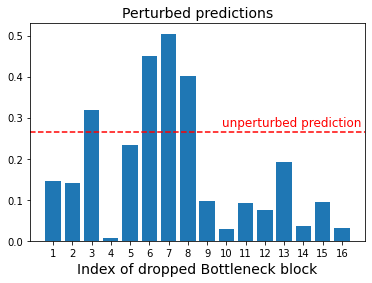

In [ ]:
plt.bar(np.arange(1, len(perturbed_predictions) + 1), perturbed_predictions)
plt.axhline(y=unperturbed_prediction, color="red", linestyle="--")
plt.text(17, unperturbed_prediction + 0.015, "unperturbed prediction", ha="right", color="red", fontsize=12)
plt.xticks(np.arange(1, len(perturbed_predictions) + 1))
plt.xlabel("Index of dropped Bottleneck block", fontsize=14)
plt.title("Perturbed predictions", fontsize=14)

plt.show()

## Question A.5: Permuting and Repeating Layers

Now, let's see what happens if we permute or repeat layers in the ResNet.

1. Permute layers: Swap `resnet50.layer2[1]` and `resnet50.layer2[3]` in the network (so that instead of the second `Bottleneck` unit in `layer2` you use the fourth and vice versa). Make predictions with the modified network. How did perturbing the model this way modify the predictions?
1. Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?
1. Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?

*15 marks*

### Answers A.5

*Please add text in this box, and use as many code cells below as you'd like.*

The unperturbed predicted probability of Border Collie from ResNet-50 on the Blas image is 0.26453596. Findings:

* Swapping `layer2[1]` and `layer2[3]` dramatically improves the ResNet-50's accuracy on the Blas image;
* Repeating `layer2[1]` twice also improves its accuracy on this image, and repeating it three times improves its accuracy even more;
* However, repeating `layer2[1]` too many times can destroy its accuracy.

In [ ]:
#1. swapping resnet50.layer2[1] and resnet50.layer2[3]
model = copy.deepcopy(resnet50)

temp = model.layer2[1]
model.layer2[1] = model.layer2[3]
model.layer2[3] = temp

model.eval()
y = model(x)
top_5_classes(y)

[('Border Collie', 0.52635115),
 ('collie', 0.19426765),
 ('Cardigan Welsh Corgi', 0.12698655),
 ('Australian Kelpie', 0.0908449),
 ('tennis ball', 0.009584237)]

In [ ]:
#2. repeating layer2 second block twice
model = copy.deepcopy(resnet50)

model.layer2 = Sequential(
    model.layer2[0],
    model.layer2[1],
    model.layer2[1],
    model.layer2[2],
    model.layer2[3]
)

model.eval()
y = model(x)
top_5_classes(y)

[('Border Collie', 0.3159974),
 ('Cardigan Welsh Corgi', 0.31416893),
 ('collie', 0.120301306),
 ('Australian Kelpie', 0.09171227),
 ('Basenji', 0.031745013)]

In [ ]:
#3.1 repeating layer2 second block 3 times
model = copy.deepcopy(resnet50)

model.layer2 = Sequential(
    model.layer2[0],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[2],
    model.layer2[3]
)

model.eval()
y = model(x)
top_5_classes(y)

[('Border Collie', 0.44836783),
 ('Australian Kelpie', 0.18681327),
 ('Cardigan Welsh Corgi', 0.099308826),
 ('collie', 0.083472155),
 ('Basenji', 0.0681161)]

In [ ]:
#3.2 repeating layer2 second block 4 times
model = copy.deepcopy(resnet50)

model.layer2 = Sequential(
    model.layer2[0],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[2],
    model.layer2[3]
)

model.eval()
y = model(x)
top_5_classes(y)

[('sea slug', 0.321546),
 ('slot machine', 0.061015215),
 ('flatworm', 0.056214835),
 ('Windsor tie', 0.033827472),
 ('goldfish', 0.02414704)]

In [ ]:
#3.2 repeating layer2 second block 5 times
model = copy.deepcopy(resnet50)

model.layer2 = Sequential(
    model.layer2[0],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[1],
    model.layer2[2],
    model.layer2[3]
)

model.eval()
y = model(x)
top_5_classes(y)

[('slot machine', 0.6489886),
 ('ring-necked snake', 0.04689378),
 ('lighter', 0.045462977),
 ('flatworm', 0.030081391),
 ('goldfish', 0.027000373)]

# B: Recurrent Networks

In this part of the assignment, we will train simple recurrent networks to detect messages hidden in binary strings.

## Backgroud

### Creating the dataset

Below, I included a function which creates a pytorch `Dataset` we will use in the questions below. 


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def get_binary_dataset(num_datapoints, signature_length=20, random_length=20):
    '''
    Creates a labelled dataset of `num_datapoints` binary sequences. Each sequence
    is of total length `signature_length + random_length`. Positive examples have
    a signature string of length `signature_length` embedded starting at a random
    location within the string. The signature is a binary string of alternating 1s
    and 0s. Negative examples are random bitstrings. They may contain the
    signature by chance, although the probability of this diminishes as the
    `signature_legth` increases.

    The returned dataset contains positive examples first, followed by negatives.
    When using minibatch-SGD, the dataset has to be shuffled before broken into
    minibatches.
 
    Attributes
    ----------
    num_datapoints : int
        Number of datapoints to be generated. Half of the datapoints will be
        positive, the rest negative. If `num_datapoints==1` then the dataset will
        contain a single positive example.
    signature_length : int
        Length of the signature string
    random_length : int
        Number of random bits in the sequence in addition to the signature sequence.
  
    Returns
    -------
    torch.utils.data.TensorDataset
        Pytorch dataset containing the strings and their binary labels.
    '''
    num_positives = num_datapoints - num_datapoints // 2
    y = np.array([[1.0]]*num_positives + [[0.0]]*(num_datapoints - num_positives))
    X = np.random.randint(2, size=(num_datapoints, signature_length + random_length))
    signature = np.array((signature_length//2)*[1.0, 0.0])
    for i in range(num_positives):
        j = np.random.randint(random_length)
        X[i, j:(j+signature_length)] = signature
    X = torch.tensor(X, dtype=torch.float)[:, :, None]
    y = torch.tensor(y)
    return TensorDataset(X, y)

Below, I visualise a dataset of $100$ positive and $100$ negative sequences of lenth $40$ each. In the visualisation below, positive examples appear on top, negatives in the bottom half. Black pixels show $1$s, white pixels show $0$s. You can see the signature sequence `10101010101010101010` embedded in the positive examples at random locations.

*Notes:* You can see how I used `spy` to visualise a sparse matrix. This function can be used to show non-zero values in a matrix. The pytorch `TensorsDataset` object has a `tensors` attribute which contains the input and output tensors.

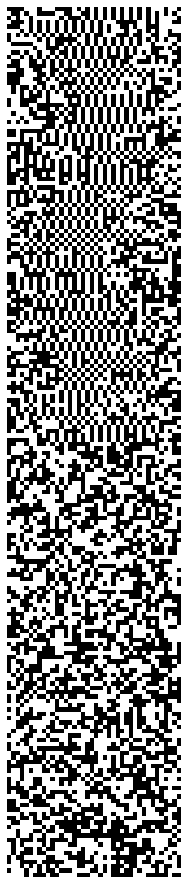

In [ ]:
from matplotlib import pylab as plt

ds = get_binary_dataset(200,
                        signature_length=20,
                        random_length=20)

plt.figure(figsize=(4, 16))
plt.spy(ds.tensors[0][:, :, 0].numpy())
plt.axis('off');

## Building a classifier

Now we're going to build a simple RNN-based classifier for classifying binary sequences. We are going to feed the sequence into an RNN, then extract the hidden state activations at the end of the sequence, finally apply a linear transformation to calculate the classifier output.

An RNN module returns two outputs, as explained in [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). We have to select a layer which selects the second output - which is the activation of the hidden state at the end of the sequence - rearranges and flattens it so it's ready to be fed into a linear layer.

*Note:* By applying a further `sigmoid`, this classifier output can be turned into a probability, like it was the case with `softmax` the ResNet example. We are not going to make the sigmoid part of the network, as training will be more numerically stable this way

In [ ]:
from torch import nn

class extract_last_cell(nn.Module):
    '''Pytorch module which extracts and flattens the last hidden state of an RNN.
    '''
    def forward(self,x):
        _ , out = x
        return out.permute(1,0,2).flatten(start_dim=1)

def get_basic_RNN_classifier():
    return nn.Sequential(
        nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
        extract_last_cell(),
        nn.Linear(in_features = 20*2, out_features=1)
    )

## Question B.1: Evaluating the loss

Evaluate the log-loss of a randomly initialized classifier on minibatches of training examples from the dataset we defined before.

*Tips:*
* you can use [`pytorch/utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to sample minibatches of training data from the dataset
* or, you can also access the input and output tensors of a `TensorDataset` directly via the `tensors` attribute
* use [`torch.nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html)

*10 marks*

### Answer B.1

*Pleasse add answer in the code cell(s) below:*

In [ ]:
from torch.nn.functional import binary_cross_entropy_with_logits

dataloader = DataLoader(ds, batch_size=10, shuffle=True)
rnn = get_basic_RNN_classifier()
for i, (X, y) in enumerate(dataloader):
    y_pred = rnn(X)
    loss = binary_cross_entropy_with_logits(y_pred, y)
    print("Batch {} loss: {}".format(i, loss))

Batch 0 loss: 0.6780781671404839
Batch 1 loss: 0.695955092459917
Batch 2 loss: 0.6841506704688072
Batch 3 loss: 0.7034100215882063
Batch 4 loss: 0.6910876829177142
Batch 5 loss: 0.7060351099818944
Batch 6 loss: 0.6878882966935634
Batch 7 loss: 0.6903674308210611
Batch 8 loss: 0.6896751817315817
Batch 9 loss: 0.6947544526308775
Batch 10 loss: 0.6981570392847061
Batch 11 loss: 0.6865362819284201
Batch 12 loss: 0.6904608134180308
Batch 13 loss: 0.6904870510101319
Batch 14 loss: 0.6953728117048741
Batch 15 loss: 0.6892534602433443
Batch 16 loss: 0.6836152330040932
Batch 17 loss: 0.6935109943151474
Batch 18 loss: 0.6880569867789745
Batch 19 loss: 0.7000040456652641


Summary: the classifier with randomly-initialised RNN weights performs poorly, but still better than random guesses.

## Training the classifier

In the previous assignment we wrote a training loop to show how optimizers work in pytorch. For this assignment we are going to use ignite, a flexible module for reusable training loops in pytorch. We will install ignite, and then I provide a function you can use to train models on the sequence data.

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 204kB 17.4MB/s 


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_model_basic(model, training_dataset, test_dataset):
    '''Fits a pytorch model to the training dataset using stochastic gradient
    descent and tracks progress on a test set.

    Arguments
    ---------
    model : pytorch.nn.Module
        pytorch model that can be evaluated on input tensor in the dataset, and
        returns a tensor that matches the shape of the output tensor.
    training_dataset : pytorch.util.data.Dataset
        used to train the model
    test_dataset : pytorch.util.data.Dataset
        used to evaluate the performance of the model at the end of each epoch

    Returns
    ------
    pytorch.nn.Module
        the model after training
    '''

    train_loader = DataLoader(
        training_dataset,
        batch_size=100,
        shuffle=True
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size=1000,
        shuffle=False,
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.BCEWithLogitsLoss()

    trainer = create_supervised_trainer(model, optimizer, criterion)

    def thresholded_output_transform(output):
        y_pred, y = output
        y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
        return y_pred, y

    val_metrics = {
        "accuracy": Accuracy(thresholded_output_transform),
        "bce": Loss(criterion)
    }
    evaluator = create_supervised_evaluator(model, metrics=val_metrics)

    @trainer.on(Events.ITERATION_COMPLETED(every=10))
    def log_training_loss(trainer):
        print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    trainer.run(train_loader, max_epochs=5)

    return model

The code above looks rather long and complicated, but that is because we ask ignite to log the progress of training in a very verbose way. Ignite uses python decorators (like the `@trainer.on(Events.EPOCH_COMPLETED)`) bits. You will find plenty of tutorials online if you google 'python decorators' if you want to learn more about them. In ignite, these decorators are used to register functions which are called when various events happen during training.

For example, `@trainer.on(Events.ITERATION_COMPLETED(every=10))` tells ignite to execute the function that's below it every 10th iteration is completed. You will find that this training loop is largely a copy of the example code provided in the [ignite master documentation](https://pytorch.org/ignite/quickstart.html#code).

One difference is that we use the `thresholded_output_transform` to tarnsform the network's output before [`Accuracy`](https://pytorch.org/ignite/metrics.html#ignite.metrics.Accuracy) metric can be evaluated. Accuracy compares binary predictions to binary labels. But our network outputs `logits` instead of binary predictors. To turn these into binary decisions, we have to determine whether the logits are above or below $0$, which is what the `heaviside` function does.

Ignite can do much more than what we ask it to do here. It's a flexible way of creating reproducible training loops for neural network training. It can handle distributed training over several machines, etc.

Let's now use our training loop to train a classifier on the binary dataset we created:

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)
rnn_classifier = get_basic_RNN_classifier()

fit_model_basic(rnn_classifier, ds_train, ds_test)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Training Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Training Results - Epoch: 3  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Epoch[4] Loss: 0.69
Training Results - Epoch: 4  Avg accuracy: 0.50 Avg loss: 0.69
Validation Results - Epoch: 4  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5] Loss: 0.69
Epoch[5]

Sequential(
  (0): RNN(1, 20, num_layers=2, batch_first=True)
  (1): extract_last_cell()
  (2): Linear(in_features=40, out_features=1, bias=True)
)

Oh no! The error doesn't seem like the loss is reduced. Let's try to fix this.

## Question B.2: Improving the SGD code

1. Create a new version of `fit_model_basic` function, call it `fit_model`. You will use this function in subsequent questions. Your function should take additional arguments allowing you to easily specify key hyperparameters of optimization: learning rate, batchsize, whatever else you find important.
1. Tune hyperparameters and change things until training works reliably. Consider [changing the optimizer](https://pytorch.org/docs/stable/optim.html) from vanilla SGD: you may try SGD with momentum, `Adam`, etc. You should be able to make this example work, i.e. reach $90\%+$ average accuarcy within a few seconds of training.

*Tips*:
 * You can try different learning rates, such as the [Karpathy constant](https://twitter.com/karpathy/status/801621764144971776). This is a joke, learning rates are usually problem-specific. Values between $0.1$ and $0.001$ are often tried.
 * If you want, you can run grid search: running training for different values of hyperparameters, and checking which one produces the best results. If doing so, consider spacing parameter values logarithmically rather than linearly. I.e. it makes more sense to try learning rates $[0.001, 0.01, 0.1]$ than to try $[0.001, 0.002, 0.003, \ldots]$.

*15 marks*

### Answer B.2

*Please modify the code in the cells below. You may use this text box to summarise the changes you made.*

Changes I made in the `fit_model` function:

1. I added options for batch size to the `DataLoader` objects;
2. I added options for optimisers and learning rates in the compiling procedure;
3. I added options for the number of epochs in the training procedure;
4. I added outputs of the final evaluation results after training is completed.

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_model(model, training_dataset, test_dataset, 
              batch_size=32, epochs=10, lr=0.001, optimizer='Adam'):
    '''Fits a pytorch model to the training dataset using stochastic gradient
    descent and tracks progress on a test set.

    Arguments
    ---------
    model : pytorch.nn.Module
        pytorch model that can be evaluated on input tensor in the dataset, and
        returns a tensor that matches the shape of the output tensor.
    training_dataset : pytorch.util.data.Dataset
        used to train the model
    test_dataset : pytorch.util.data.Dataset
        used to evaluate the performance of the model at the end of each epoch

    Returns
    ------
    pytorch.nn.Module
        the model after training
    '''

    train_loader = DataLoader(
        training_dataset,
        batch_size=batch_size,  # Add options for batch size
        shuffle=True
    )
    val_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,  # Add options for batch size
        shuffle=False,
    )

    # Add options for optimizers and learning rates
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise NotImplementedError("Either this is an invalid optimizer name, or I haven't implemented it!")
    criterion = nn.BCEWithLogitsLoss()

    trainer = create_supervised_trainer(model, optimizer, criterion)

    def thresholded_output_transform(output):
        y_pred, y = output
        y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
        return y_pred, y

    val_metrics = {
        "accuracy": Accuracy(thresholded_output_transform),
        "bce": Loss(criterion)
    }
    evaluator = create_supervised_evaluator(model, metrics=val_metrics)

    @trainer.on(Events.ITERATION_COMPLETED(every=50))
    def log_training_loss(trainer):
        print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

    trainer.run(train_loader, max_epochs=epochs)  # Add options for epochs

    # Add final evaluation results
    final_eval_results = {}

    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Final training Results - Epochs: {epochs}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
    final_eval_results['train_accuracy'] = metrics['accuracy']
    final_eval_results['train_loss'] = metrics['bce']

    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Final validation Results - Epochs: {epochs}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")
    final_eval_results['val_accuracy'] = metrics['accuracy']
    final_eval_results['val_loss'] = metrics['bce']    

    return model, final_eval_results

In [ ]:
# to make the output stable across runs
def init_random_seed(seed):
    torch.manual_seed(seed)  
    np.random.seed(seed)

init_random_seed(1)

batch_sizes = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'RMSprop']

max_val_accuracy = -1
best_combination = {}

# In this cell, I have commented out the on-training decorators in fit_model to simplify the outputs
for batch_size in batch_sizes:
    for lr in learning_rates:
        for optimizer in optimizers:
            print(f"Batch size: {batch_size}, learning rate: {lr}, optimizer: {optimizer}")
            classifier, final_eval_results = fit_model(
                get_basic_RNN_classifier(), ds_train, ds_test, 
                batch_size=batch_size, epochs=10, lr=lr, optimizer=optimizer
            )
            if final_eval_results['val_accuracy'] > max_val_accuracy:
                max_val_accuracy = final_eval_results['val_accuracy']
                best_combination['batch_size'] = batch_size
                best_combination['lr'] = lr
                best_combination['optimizer'] = optimizer
            print()

best_combination

Batch size: 32, learning rate: 0.001, optimizer: SGD
Final training Results - Epochs: 10  Avg accuracy: 0.50 Avg loss: 0.69
Final validation Results - Epochs: 10  Avg accuracy: 0.50 Avg loss: 0.69

Batch size: 32, learning rate: 0.001, optimizer: Adam
Final training Results - Epochs: 10  Avg accuracy: 0.98 Avg loss: 0.06
Final validation Results - Epochs: 10  Avg accuracy: 0.98 Avg loss: 0.07

Batch size: 32, learning rate: 0.001, optimizer: RMSprop
Final training Results - Epochs: 10  Avg accuracy: 0.99 Avg loss: 0.06
Final validation Results - Epochs: 10  Avg accuracy: 0.98 Avg loss: 0.07

Batch size: 32, learning rate: 0.01, optimizer: SGD
Final training Results - Epochs: 10  Avg accuracy: 0.50 Avg loss: 0.69
Final validation Results - Epochs: 10  Avg accuracy: 0.49 Avg loss: 0.69

Batch size: 32, learning rate: 0.01, optimizer: Adam
Final training Results - Epochs: 10  Avg accuracy: 0.73 Avg loss: 0.54
Final validation Results - Epochs: 10  Avg accuracy: 0.75 Avg loss: 0.51

Batch 

{'batch_size': 32, 'lr': 0.001, 'optimizer': 'Adam'}

In [ ]:
# to make the output stable across runs
init_random_seed(1)

# Best batch size: 32, best learning rate: 0.001, best optimizer: Adam
rnn_classifier, final_eval_results = fit_model(
    get_basic_RNN_classifier(), ds_train, ds_test, 
    batch_size=best_combination['batch_size'], epochs=10, 
    lr=best_combination['lr'], 
    optimizer=best_combination['optimizer']
)

Epoch[1] Loss: 0.70
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.70
Training Results - Epoch: 1  Avg accuracy: 0.51 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Validation Results - Epoch: 3  Avg accuracy: 0.53 Avg loss: 0.69
Epoch[4] Loss: 0.67
Epoch[4] Loss: 0.37
Epoch[4] Loss: 0.12
Training Results - Epoch: 4  Avg accuracy: 0.94 Avg loss: 0.15
Validation Results - Epoch: 4  Avg accuracy: 0.95 Avg loss: 0.13
Epoch[5] Loss: 0.06
Epoch[5] Loss: 0.05
Epoch[5] Loss: 0.02
Training Results - Epoch: 5  Avg accuracy: 0.97 Avg loss: 0.10
Validation Results - Epoch: 5  Avg accuracy: 0.97 Avg loss: 0.11
Epoch[6] Loss: 0.06
Epoch[6] Loss: 0.22
Epoch[6] Loss: 0.06


Summary:

* The classifier is unable to train with a too large learning rate (i.e. 0.01 and 0.1);
* The classifier is unable to train with SGD, and improved SGDs such as Adam and RMSprop can boost its training performance;
* The classifier is able to finish training with a very good result even with a small number of epochs (i.e. 10);
* It is worth pointing out that different random seeds do affect the final outcome: for some seeds, the classifier performs better with a batch size of 64 and using RMSprop, instead of a batch size of 32 and Adam.

## Question B.3: Test on longer sequences

Now that you successfully trained an RNN, let's test how well it works when we use it on longer sequences than what it was trained on. Does it have the ability to remember? Remember we trained on datasets with `signature_length=10, random_length=10`, that is a total length of `20` binary symbols.

* create 5 test datasets with `signature_length` of $10$ but with different `random_length` parameters (e.g. $10$, $20$, $30$, $50$ and $100$)
* evaluate accuracy of your trained model on each of these test regimes - (without retraining!)
* plot the performance you achieve for different test sequence lengths
* describe what you find

*Tips:*
* look inside the `fit_model` function for tips on evaluating models using ignite components.

*20 marks*

### Answers B.3

*Please complete the task in code cells below.*

In [ ]:
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
    return y_pred, y

val_metrics = {
    "accuracy": Accuracy(thresholded_output_transform),
    "bce": Loss(nn.BCEWithLogitsLoss())
}

evaluator = create_supervised_evaluator(rnn_classifier, metrics=val_metrics)

In [ ]:
# to make the output stable across runs
init_random_seed(1)

signature_length = 10
random_lengths = [10, 20, 30, 50, 100]
accuracies = []
losses = []

for random_length in random_lengths:
    ds_test_extended = get_binary_dataset(1000, signature_length=signature_length, random_length=random_length)
    test_loader = DataLoader(ds_test_extended, batch_size=best_combination['batch_size'], shuffle=False)

    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print(f"Test dataset with signature_length = {signature_length}, random_length = {random_length}:")
    print(f"Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}\n")
    accuracies.append(metrics['accuracy'])
    losses.append(metrics['bce'])

Test dataset with signature_length = 10, random_length = 10:
Avg accuracy: 0.98 Avg loss: 0.07

Test dataset with signature_length = 10, random_length = 20:
Avg accuracy: 0.84 Avg loss: 0.64

Test dataset with signature_length = 10, random_length = 30:
Avg accuracy: 0.72 Avg loss: 1.38

Test dataset with signature_length = 10, random_length = 50:
Avg accuracy: 0.66 Avg loss: 1.76

Test dataset with signature_length = 10, random_length = 100:
Avg accuracy: 0.58 Avg loss: 2.24



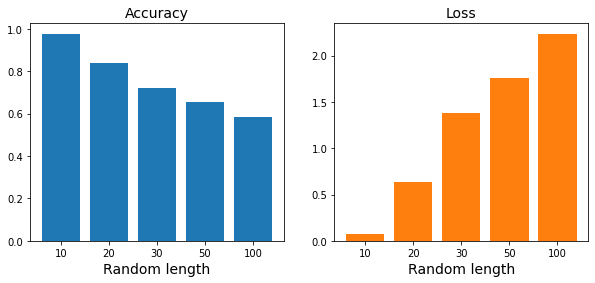

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar([str(length) for length in random_lengths], accuracies)
ax1.set_xlabel("Random length", fontsize=14)
ax1.set_title("Accuracy", fontsize=14)

ax2.bar([str(length) for length in random_lengths], losses, color='tab:orange')
ax2.set_xlabel("Random length", fontsize=14)
ax2.set_title("Loss", fontsize=14)

plt.show()

Summary:

* The classifier is able to generalise to longer sequences, though its accuracy may decrease;
* However, the classifier is unable to generalise to sequences that are too long (for example, 100).

## Question B.4: Better models

Remember what we learned about vanilla RNN's ability to remember information over long time range. Pick a different RNN cell type that should have better ability to remember, and define a new network that uses this cell type. 
* Modify the function below to define an improved RNN classifier
* train an instance of this better RNN model on the same data we trained the previous classifier on
* repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

*15 marks*

### Answers B.4

*Please edit the code below and add as many code cells as you would like to complete this task.*

In [ ]:
def get_better_RNN_classifier():
    '''A better RNN architecture for solving the signature detection problem.
    '''
    return nn.Sequential(
        nn.GRU(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
        extract_last_cell(),
        nn.Linear(in_features=20 * 2, out_features=1)
    )

In [ ]:
# to make the output stable across runs
init_random_seed(1)

gru_classifier, final_eval_results = fit_model(get_better_RNN_classifier(), ds_train, ds_test)

Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Epoch[1] Loss: 0.69
Training Results - Epoch: 1  Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch: 1  Avg accuracy: 0.50 Avg loss: 0.69
Epoch[2] Loss: 0.69
Epoch[2] Loss: 0.70
Epoch[2] Loss: 0.69
Training Results - Epoch: 2  Avg accuracy: 0.49 Avg loss: 0.69
Validation Results - Epoch: 2  Avg accuracy: 0.49 Avg loss: 0.69
Epoch[3] Loss: 0.69
Epoch[3] Loss: 0.68
Epoch[3] Loss: 0.56
Training Results - Epoch: 3  Avg accuracy: 0.67 Avg loss: 0.61
Validation Results - Epoch: 3  Avg accuracy: 0.69 Avg loss: 0.60
Epoch[4] Loss: 0.59
Epoch[4] Loss: 0.31
Epoch[4] Loss: 0.07
Training Results - Epoch: 4  Avg accuracy: 0.96 Avg loss: 0.11
Validation Results - Epoch: 4  Avg accuracy: 0.96 Avg loss: 0.12
Epoch[5] Loss: 0.03
Epoch[5] Loss: 0.05
Epoch[5] Loss: 0.01
Training Results - Epoch: 5  Avg accuracy: 0.99 Avg loss: 0.05
Validation Results - Epoch: 5  Avg accuracy: 0.99 Avg loss: 0.06
Epoch[6] Loss: 0.01
Epoch[6] Loss: 0.01
Epoch[6] Loss: 0.01


In [ ]:
# to make the output stable across runs
init_random_seed(1)

signature_length = 10
random_lengths = [10, 20, 30, 50, 100]
new_accuracies = []
new_losses = []

evaluator = create_supervised_evaluator(gru_classifier, metrics=val_metrics)

for random_length in random_lengths:
    ds_test_extended = get_binary_dataset(1000, signature_length=signature_length, random_length=random_length)
    test_loader = DataLoader(ds_test_extended, batch_size=best_combination['batch_size'], shuffle=False)

    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    print(f"Test dataset with signature_length = {signature_length}, random_length = {random_length}:")
    print(f"Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}\n")
    new_accuracies.append(metrics['accuracy'])
    new_losses.append(metrics['bce'])

Test dataset with signature_length = 10, random_length = 10:
Avg accuracy: 1.00 Avg loss: 0.02

Test dataset with signature_length = 10, random_length = 20:
Avg accuracy: 0.99 Avg loss: 0.03

Test dataset with signature_length = 10, random_length = 30:
Avg accuracy: 0.97 Avg loss: 0.12

Test dataset with signature_length = 10, random_length = 50:
Avg accuracy: 0.94 Avg loss: 0.29

Test dataset with signature_length = 10, random_length = 100:
Avg accuracy: 0.77 Avg loss: 1.36



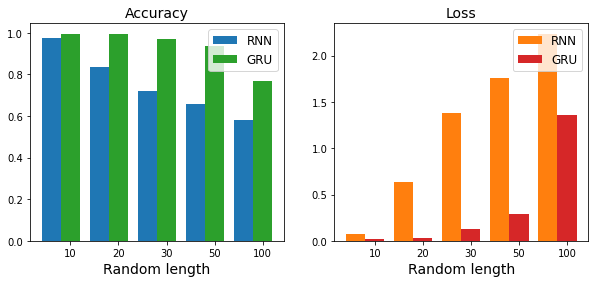

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
bar_width = 0.4

ax1.bar(np.arange(len(random_lengths)), accuracies, width=bar_width, color='tab:blue', label='RNN')
ax1.bar(np.arange(len(random_lengths)) + bar_width, new_accuracies, width=bar_width, color='tab:green', label='GRU')
ax1.set_xticks(np.arange(len(random_lengths)) + bar_width)
ax1.set_xticklabels([str(length) for length in random_lengths])
ax1.set_xlabel("Random length", fontsize=14)
ax1.set_title("Accuracy", fontsize=14)
ax1.legend(loc='upper right', fontsize=12)

ax2.bar(np.arange(len(random_lengths)), losses, width=bar_width, color='tab:orange', label='RNN')
ax2.bar(np.arange(len(random_lengths)) + bar_width, new_losses, width=bar_width, color='tab:red', label='GRU')
ax2.set_xticks(np.arange(len(random_lengths)) + bar_width)
ax2.set_xticklabels([str(length) for length in random_lengths])
ax2.set_xlabel("Random length", fontsize=14)
ax2.set_title("Loss", fontsize=14)
ax2.legend(loc='upper right', fontsize=12)

plt.show()

Summary:

* The GRU classifier does perform better than the RNN classifier, both on the original task, and on the ability to generalise to longer sequences;
* It is worth pointing out that different random seeds do affect the final outcome: for some seeds, the GRU classifier performs no better than the RNN classifier, and sometimes even worse.

## Question B.5: Visualise memorization

Now we are going to visualize which parts of the input the trained architecture pays attention to when making its decision. This is going to be similar in spirit to [this distill post](https://distill.pub/2019/memorization-in-rnns/).
* take your pre-trained RNN classifier from the previous example
* generate a random positive input sequence (one that has a signature of length $10$ in it) and form an input tensor to the model.
* calculate the gradient of the model's output with respect to the input.

*Tips:*
* remember how we used `requires_grad` and `backward` and the `grad` attribute in the lecture to calculate the gradients of an RNN's hidden state with respect to the input sequence.
* remember the `TensorDataset` has a `tensors` argument which you can use to extract the input and output tensors from the dataset.

*15 marks*

### Answers B.5

*Please add your solution to the code blocks below.*

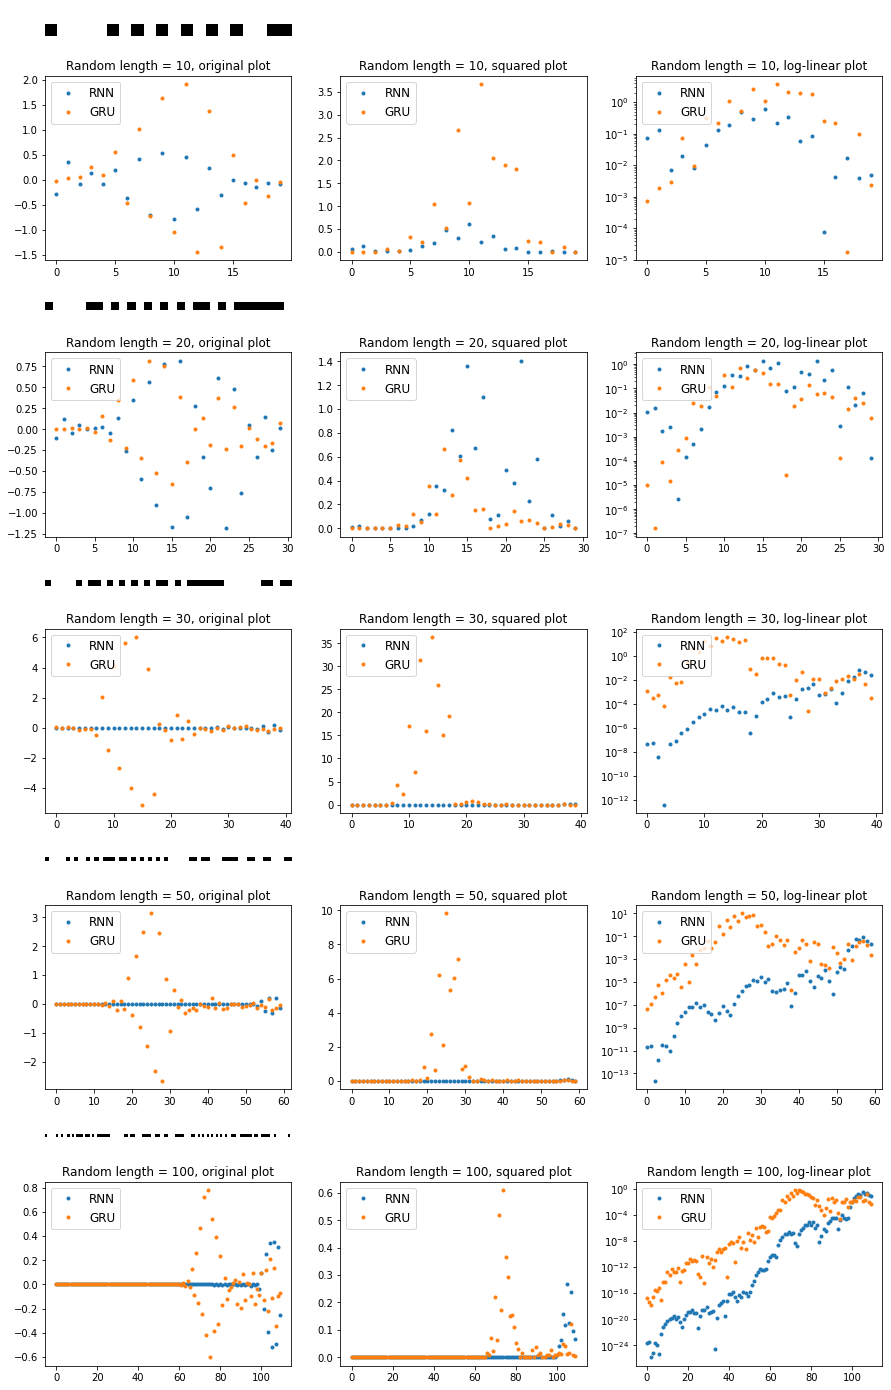

In [ ]:
signature_length = 10
random_lengths = [10, 20, 30, 50, 100]

with plt.rc_context({'figure.figsize': (5 * 3, 5 * len(random_lengths))}):
    fig, ax = plt.subplots(len(random_lengths) * 2, 3,
                           gridspec_kw={'height_ratios':[1, 4] * len(random_lengths)})

for i, random_length in enumerate(random_lengths):
    # to make the output stable across runs
    init_random_seed(20210319)

    # Since num_positives = num_datapoints - num_datapoints // 2, this sequence must be positive
    input_ds = get_binary_dataset(1, signature_length=signature_length, random_length=random_length)
    input_loader = DataLoader(input_ds)
    input, _ = iter(input_loader).next()
    ax[2 * i, 0].spy(input[:, :, 0].numpy())

    rnn_input = copy.deepcopy(input)
    rnn_input.requires_grad = True
    rnn_output = rnn_classifier(rnn_input)
    rnn_output.backward()
    rnn_input_grad = rnn_input.grad[0, :, 0].detach().numpy()
    ax[2 * i + 1, 0].plot(rnn_input_grad, ".", label="RNN")
    ax[2 * i + 1, 1].plot(rnn_input_grad ** 2, ".", label="RNN")
    ax[2 * i + 1, 2].semilogy(rnn_input_grad ** 2, ".", label="RNN")

    gru_input = copy.deepcopy(input)
    gru_input.requires_grad = True
    gru_output = gru_classifier(gru_input)
    gru_output.backward()
    gru_input_grad = gru_input.grad[0, :, 0].detach().numpy()
    ax[2 * i + 1, 0].plot(gru_input_grad, ".", label="GRU")
    ax[2 * i + 1, 1].plot(gru_input_grad ** 2, ".", label="GRU")
    ax[2 * i + 1, 2].semilogy(gru_input_grad ** 2, ".", label="GRU")

    ax[2 * i + 1, 0].set_title(f'Random length = {random_length}, original plot', fontsize=12)
    ax[2 * i + 1, 1].set_title(f'Random length = {random_length}, squared plot', fontsize=12)
    ax[2 * i + 1, 2].set_title(f'Random length = {random_length}, log-linear plot', fontsize=12)
    
    for j in range(3):
        ax[2 * i, j].axis('off')
        ax[2 * i + 1, j].legend(loc='upper left', fontsize=12)

plt.show()

Summary:

* In all input cases for the GRU classifier and in the cases where `random_length` is small for the RNN classifier (i.e. when the RNN classifier performs well), gradients get large where the signature is in the sequence, which suggests that both classifiers know to concentrate on the signature;
* The GRU classifier does have a better ability in memorising earlier subsequences than the RNN classifier;
* For seeing which part of the sequence does a classifier concentrate on, the original plot and the square plot illustrate better than the log-linear plot;
* For seeing the vanishing gradient characteristics, the log-linear plot illustrates better than the other two unscaled plots, by showing a nice downward plot from the end to the beginning;
* When the gradients of the RNN classifier and the GRU classifier are both very close to zero, their differences become more notable on the log-linear plot;
* It is worth pointing out that different random seeds do affect the final outcome: for some seeds, the difference between the GRU classifier and the RNN classifier are less significant, and sometimes even indistinguishable.

## C Mini-Projects

Please **choose one** of the proposed mini-project questions below. Add as many text and code cells under the heading as you'd like. You may attempt more than one, but we will only mark one: please write below which mini-project you'd like to get marked on:

**I would like my solution for mini-project *C.1* to be marked.**

## C.1: Adversarial examples for ResNets

Adversarial examples for image classifiers are images which have been imperceptibly changed such that the classifier's output changes. For example, below we see an image of a panda, which the network correctly classifies as panda (left), but when we add a small amount of structured noise (middle), and feed the modified image (right) into the classifier, it now classifies it is a gibbon with high confidence.

![](https://openai.com/content/images/2017/02/adversarial_img_1.png)

In this mini-project, your task is to generate an adversarial example for a pretrained convolutional neural network of your choice (VGG19, ResNet18 or ResNet50 are good choices). Use the image of Blas as a starting point. Change the image of Blas imperceptibly so that your network misclassifies him as a bus or sea slug, or any other arbitrary ImageNet class which is clearly not a dog. I recommend using the *fast gradient sign* method described on page 3 of [(Szegedy et al, 2013)](https://arxiv.org/pdf/1412.6572.pdf). *(40 marks)*

For full marks, explore the topic a bit more, example questions you can ask:
* Can you deliberately control what class you get after the adversarial attack? *(~20 marks)*
* Does the adversarial example generated for one network fool other networks, too? *(~20 marks for non-minimal investigation and good writeup)*
* Load another image. Does the adversarial noise generated for one image work to fool the network when added to a different image *(~20 marks for for non-minimal investigation and good writeup)*
* Can you generate adversarial examples without access to gradients, only using the forward pass of the network (this is called black-box adversarial attack)? *(~40 marks)*

*Tips:*
* The *fast gradient sign* method relies on gradients of the network's output with respect to pixel values in image space: you are looking for the smallest change to pixel values which maximally change the classifier's outputs. Remember how we did this using `requires_gradients` and `backward` in the RNN example.
* To illustrate the change is imperceptible, you want to apply the change to the untransformed image, i.e. before the normalisation is applied. The normalization is itself differentiable, so my advice is to make the normalization part of the network itself.

*80 marks*

### Adversarial examples for ResNet-50

#### Fast gradient sign method (FGSM) attack

For this task, I will try to generate adversarial examples for a pretrained ResNet-50. Firstly, output the the pretrained ResNet-50's predictions of the clean Blas image for baseline comparison:

In [ ]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
x = img_t.unsqueeze(0)
y = resnet50(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


[('Border Collie', 0.26453617),
 ('collie', 0.18160026),
 ('Cardigan Welsh Corgi', 0.17722456),
 ('Whippet', 0.12113578),
 ('Australian Kelpie', 0.05963931)]

Then define the transforms. I have split the previously defined transform into a resize-and-crop transform and a normalisation transform, because the resize-and-crop transformation is not differentiable and shoule be separated.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

Now output the clean Blas image after the resize-and-crop transformation, also for baseline comparison:

Clean image, prediction: Border Collie (26.45% confidence)


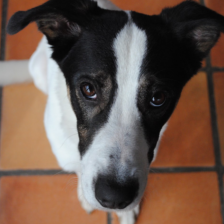

In [ ]:
from torchvision.transforms.functional import to_pil_image

print('Clean image, prediction: Border Collie (26.45% confidence)')
to_pil_image(transform(img))

Now define the function for calculating the gradient signs. I can also visualise the calculated gradient signs:

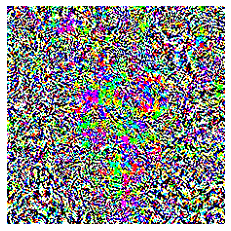

In [ ]:
import copy
from torch.nn.functional import nll_loss

def get_gradient_sign(model, input, label_index):
    x = copy.deepcopy(input)
    x.requires_grad = True
    x_norm = normalise(x).unsqueeze(0)
    y = model(x_norm)

    loss = nll_loss(y, torch.tensor([label_index]))
    model.zero_grad()
    loss.backward()
    gradient = x.grad.data

    gradient_sign = gradient.sign().detach().numpy()
    return gradient_sign

model = copy.deepcopy(resnet50)
border_collie_index = 232
gradient_sign = get_gradient_sign(model, transform(img), border_collie_index)
plt.imshow(np.moveaxis(gradient_sign, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

The FGSM attack proposed by [Goodfellow et al. (2014)](https://arxiv.org/pdf/1412.6572.pdf) is to perturb the clean image with a small amount of its loss gradient signs, in order to maximise the loss function. This can be described by the following formula:

$$\boldsymbol{X}^\textit{adv}=\boldsymbol{X}+\epsilon\text{sign}(\nabla_\boldsymbol{X}J(\boldsymbol{\theta},\boldsymbol{X},y_\textit{true}))$$

where

* $\boldsymbol{X}$ is the clean image;
* $y_\textit{true}$ is the true class for the clean image $\boldsymbol{X}$;
* $\boldsymbol{\theta}$ is the parameters of the model;
* $J(\boldsymbol{\theta},\boldsymbol{X},y_\textit{true})$ is the cost function used to train the model;
* $\epsilon$ is the size of the adversarial perturbation, which is a hyper-parameter to be chosen.

Now implement the FGSM attack and apply it to ResNet-50:

In [ ]:
def fgsm_attack(image, gradient_sign, epsilon):
    perturbed_image = transform(image) + epsilon * gradient_sign
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
epsilons = np.arange(0., 0.301, 0.01)
fgsm_examples = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img, gradient_sign, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'Border Collie':
        fgsm_examples[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('Border Collie', 0.26453617)
Epsilon = 0.01, classification result: ('Boston Terrier', 0.15633516)
Epsilon = 0.02, classification result: ('Boston Terrier', 0.38097718)
Epsilon = 0.03, classification result: ('Boston Terrier', 0.44694325)
Epsilon = 0.04, classification result: ('American Staffordshire Terrier', 0.40857342)
Epsilon = 0.05, classification result: ('Boston Terrier', 0.43188256)
Epsilon = 0.06, classification result: ('Boston Terrier', 0.6337998)
Epsilon = 0.07, classification result: ('Boston Terrier', 0.79243284)
Epsilon = 0.08, classification result: ('Boston Terrier', 0.8881545)
Epsilon = 0.09, classification result: ('Boston Terrier', 0.92927015)
Epsilon = 0.1, classification result: ('Boston Terrier', 0.952937)
Epsilon = 0.11, classification result: ('Boston Terrier', 0.73149)
Epsilon = 0.12, classification result: ('Boston Terrier', 0.40383962)
Epsilon = 0.13, classification result: ('Boston Terrier', 0.27153036)
Epsilon = 0.14

We can see that when $\epsilon < 0.17$, even though ResNet-50 stops classifying Blas as a Border Collie, it can still recognise Blas as a dog. Even when $\epsilon \geq 0.17$, ResNet-50 misclassifies Blas as something far from a dog, its top-1 prediction confidence is still very low.

Now view the perturbed adversarial image with $\epsilon = 0.17$, where ResNet-50 misclassifies the image as a fountain with condidence 0.038:

Epsilon = 0.17, prediction: fountain (3.79% confidence)


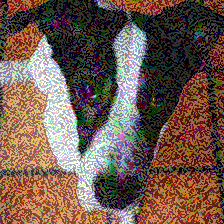

In [ ]:
print(f"Epsilon = 0.17, prediction: fountain (3.79% confidence)")
to_pil_image(fgsm_examples[0.17])

The noise is clearly perceptible to human eyes, which is not very satisfactory.

#### Iterative fast gradient sign method (IFGSM) attack

Now I will try the iterative fast gradient sign method (IFGSM) attack, which is a straightforward extension of FGSM by apply it multiple times with small step size, proposed by [Kurakin et al. (2016)](https://arxiv.org/abs/1607.02533). Its formula can be expressed as

$$\begin{align*}
&\boldsymbol{X}_0^\textit{adv}=\boldsymbol{X} \\
&\boldsymbol{X}_{n+1}^\textit{adv}=\textit{Clip}_{\boldsymbol{X},\epsilon}\Big(\boldsymbol{X}_n^\textit{adv}+\alpha\text{sign}(\nabla_\boldsymbol{X}J(\boldsymbol{\theta},\boldsymbol{X}_n^\textit{adv},y_\textit{true}))\Big)
\end{align*}$$

where

* $\epsilon$ is now the maximum adversarial perturbation on the clean image $\boldsymbol{X}$, which is still a hyper-parameter to be chosen;
* $\alpha$ is the size of the adversarial perturbation per step, which is also a hyper-parameter to be chosen;
* ${Clip}_{\boldsymbol{X},\epsilon}(\boldsymbol{A})$ denotes element-wise clipping of $\boldsymbol{A}$, with $A_{i,j}$ clipped into the range $\big[\max{(0,X_{i,j}-\epsilon)}, \min{(1,X_{i,j}+\epsilon)}\big]$.

In this experiment I chose the number of iterations $N$ to be $\lfloor\min{(255\epsilon+4,1.25\times(255\epsilon))}\rfloor$, as suggested by [Kurakin et al. (2016)](https://arxiv.org/abs/1607.02533), and set $\alpha = \epsilon / N$. Below is the implementation of the IFGSM attack on ResNet-50:

In [ ]:
def clip(input, x, epsilon):
    min_value = torch.maximum(torch.zeros(x.size()), x - epsilon)
    max_value = torch.minimum(torch.ones(x.size()), x + epsilon)
    return torch.minimum(torch.maximum(input, min_value), max_value)

def ifgsm_attack(model, image, label_index, epsilon, N):
    alpha = 0 if N == 0 else epsilon / N
    perturbed_image = transform(image)
    for i in range(N):
        gradient_sign = get_gradient_sign(model, perturbed_image, label_index)
        perturbed_image = perturbed_image + alpha * gradient_sign
        perturbed_image = clip(perturbed_image, transform(image), epsilon)
    return perturbed_image

In [ ]:
epsilons = np.arange(0., 0.101, 0.005)
ifgsm_examples = {}

for epsilon in epsilons:
    N = int(min(255 * epsilon + 4, 1.25 * 255 * epsilon))
    img_perturbed = ifgsm_attack(model, img, border_collie_index, epsilon, N)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, N = {}, classification result: {}".format(epsilon, N, new_top_1_class))
    if new_top_1_class[0] != 'Border Collie':
        ifgsm_examples[epsilon] = img_perturbed

Epsilon = 0.0, N = 0, classification result: ('Border Collie', 0.26453617)
Epsilon = 0.005, N = 1, classification result: ('Great Dane', 0.15417494)
Epsilon = 0.01, N = 3, classification result: ('Boxer', 0.30886003)
Epsilon = 0.015, N = 4, classification result: ('Great Dane', 0.3156439)
Epsilon = 0.02, N = 6, classification result: ('Boxer', 0.7201322)
Epsilon = 0.025, N = 7, classification result: ('Boxer', 0.26452625)
Epsilon = 0.03, N = 9, classification result: ('barbell', 0.21584861)
Epsilon = 0.035, N = 11, classification result: ('ladle', 0.30856574)
Epsilon = 0.04, N = 12, classification result: ('rotisserie', 0.31264263)
Epsilon = 0.045, N = 14, classification result: ('rotisserie', 0.2859337)
Epsilon = 0.05, N = 15, classification result: ('rotisserie', 0.27286965)
Epsilon = 0.055, N = 17, classification result: ('rotisserie', 0.62457734)
Epsilon = 0.06, N = 19, classification result: ('ladle', 0.5096055)
Epsilon = 0.065, N = 20, classification result: ('spatula', 0.9090282

This time ResNet-50 quickly stops recognising Blas as a dog from $\epsilon=0.03$ with decent confidence, and even thinks Blas is a spatula with confidence 0.91 at $\epsilon=0.065$. Now let's show the perturbed image with $\epsilon=0.065$:

Epsilon = 0.065, N = 20, prediction: spatula (90.90% confidence)


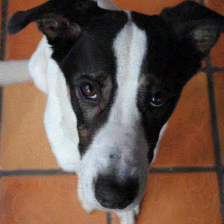

In [ ]:
print(f"Epsilon = 0.065, N = 20, prediction: spatula (90.90% confidence)")
to_pil_image(ifgsm_examples[0.065])

Now the perturbation is also imperceptible. From the above experiments we can see that although IFGSM is slower than FGSM, it is much more successful in adversarial attacking, both in the sense of top-1 prediction confidence and the perturbation imperceptibilities.

### Targeted adversarial attack

FGSM finds adversarial perturbations with increase the value of the loss function. As an alternative appoach, maximising probability $\Pr(y_\textit{target}|\boldsymbol{X})$ of some specific target class $y_\textit{target}$ for a given image.

#### Targeted fast gradient sign method (T-FGSM) attack

For a neural network with cross-entropy loss, the formula of the FGSM attack can be slightly modified to maximise $\Pr(y_\textit{target}|\boldsymbol{X})$:

$$\boldsymbol{X}^\textit{adv}=\boldsymbol{X}-\epsilon\text{sign}(\nabla_\boldsymbol{X}J(\boldsymbol{\theta},\boldsymbol{X},y_\textit{target}))$$

Firstly, try with an arbitrarily chosen target class:

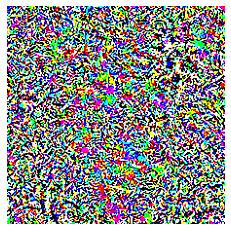

In [ ]:
minibus_index = 654
gradient_sign = get_gradient_sign(model, transform(img), minibus_index)
plt.imshow(np.moveaxis(gradient_sign, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

In [ ]:
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples = {}

for epsilon in epsilons:
    # Invert the sign of epsilon to apply T-FGSM attack
    img_perturbed = fgsm_attack(img, gradient_sign, -epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'Border Collie':
        t_fgsm_examples[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.17196792)
Epsilon = 0.01, classification result: ('Basenji', 0.30445087)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.42876548)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.63558275)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.44359618)
Epsilon = 0.05, classification result: ('ram', 0.30541384)
Epsilon = 0.06, classification result: ('Boston Terrier', 0.17965303)
Epsilon = 0.07, classification result: ('Boston Terrier', 0.09557182)
Epsilon = 0.08, classification result: ('bath towel', 0.09813595)
Epsilon = 0.09, classification result: ('sock', 0.23787792)
Epsilon = 0.1, classification result: ('sock', 0.39129686)
Epsilon = 0.11, classification result: ('sock', 0.41925037)
Epsilon = 0.12, classification result: ('sock', 0.41736117)
Epsilon = 0.13, classification result: ('sock', 0.3317394)
Epsilon = 0.14, classification result: ('sock', 0.2065281)
Epsilon = 0.

Minibus doen't show up for $\epsilon \leq 0.3$... 

Now let's try if it can even come up:

In [ ]:
epsilons = np.arange(0., 1.001, 0.01)
t_fgsm_examples = {}

for epsilon in epsilons:
    # Invert the sign of epsilon to apply T-FGSM attack
    img_perturbed = fgsm_attack(img, gradient_sign, -epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    if new_top_1_class[0] == 'minibus':
        print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
        t_fgsm_examples[epsilon] = img_perturbed

print('Finish')

Finish


It seems T-FGSM cannot force ResNet-50 to classify Blas as a minibus no matter what value $\epsilon$ takes. However, we don't have to give up here: as [Kurakin et al. (2016)](https://arxiv.org/abs/1607.02533) suggested, we can use the least likely class predicted by the network 

$$y_\textit{LL}=\underset{y}{\arg\min}\ \Pr(y|\boldsymbol{X})$$

to be the target class:

In [ ]:
def last_1_class(y, class_names=None):
    if class_names == None:
        imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
        response = requests.get(imagenet_labels_url)
        class_names = json.loads(response.text)
    p = softmax(y[0,:], dim=0)
    values, indices = p.topk(1, largest=False)
    index = indices.detach().numpy()[0]
    value = values.detach().numpy()[0]
    return index, class_names[index], value 

x = img_t.unsqueeze(0)
y = resnet50(x)
top_5_classes(y)
last_1_class(y)

(135, 'limpkin', 1.4905858e-08)

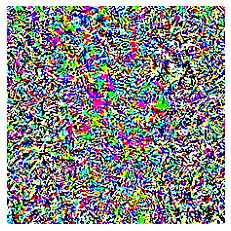

In [ ]:
limpkin_index = 135
gradient_sign = get_gradient_sign(model, transform(img), limpkin_index)
plt.imshow(np.moveaxis(gradient_sign, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

In [ ]:
epsilons = np.arange(0., 1.001, 0.01)
t_fgsm_ll_examples = {}

for epsilon in epsilons:
    # Invert the sign of epsilon to apply T-FGSM attack
    img_perturbed = fgsm_attack(img, gradient_sign, -epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    if new_top_1_class[0] == 'limpkin':
        print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
        t_fgsm_ll_examples[epsilon] = img_perturbed

print('Finish')

Finish


It seems that even using this method, T-FGSM cannot force ResNet-50 to classify Blas as the least likely class, limpkin, no matter what value $\epsilon$ takes. However, this does not mean T-FGSM attack doesn't work: let's take a closer look at its performance:

In [ ]:
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_ll_examples = {}

for epsilon in epsilons:
    # Invert the sign of epsilon to apply T-FGSM attack
    img_perturbed = fgsm_attack(img, gradient_sign, -epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'Border Collie':
        t_fgsm_ll_examples[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.17196792)
Epsilon = 0.01, classification result: ('Border Collie', 0.11813864)
Epsilon = 0.02, classification result: ('Border Collie', 0.10644791)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.2061418)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.27939928)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.36879042)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.4224134)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.34472865)
Epsilon = 0.08, classification result: ('Cardigan Welsh Corgi', 0.19935389)
Epsilon = 0.09, classification result: ('Cardigan Welsh Corgi', 0.077869095)
Epsilon = 0.1, classification result: ('doormat', 0.09609228)
Epsilon = 0.11, classification result: ('jigsaw puzzle', 0.110281974)
Epsilon = 0.12, classification result: ('jigsaw puzzle', 0.14013481)
Epsilon = 0.13, classification result: ('prayer rug', 0

As we can see, under the T-FGSM attack, ResNet-50 starts to output non-dog prediction at an $\epsilon$ smaller than under the FGSM attack, and its confidence on misclassified result is also improved. Therefore, even though T-FGSM cannot force ResNet-50 to specified predictions, it is still an improvement compared to FGSM. As a final remark, let's see the perturbed image at $\epsilon=0.15$, where ResNet-50 misclassifies it as a breastplate, with confidence 0.035:

Epsilon = 0.15, prediction: breastplate (3.46% confidence)


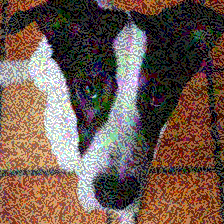

In [ ]:
print(f"Epsilon = 0.15, prediction: breastplate (3.46% confidence)")
to_pil_image(t_fgsm_ll_examples[0.15])

The perturbation is still perceptible, but slightly less obvious than $\epsilon=0.17$ in the FGSM attack experiment.

#### Targeted iterative fast gradient sign method (T-IFGSM) attack

Similar to FGSM, the IFGSM attack formula can also be slightly modified to become a targeted attack (T-IFGSM):

$$\begin{align*}
&\boldsymbol{X}_0^\textit{adv}=\boldsymbol{X} \\
&\boldsymbol{X}_{n+1}^\textit{adv}=\textit{Clip}_{\boldsymbol{X},\epsilon}\Big(\boldsymbol{X}_n^\textit{adv}-\alpha\text{sign}(\nabla_\boldsymbol{X}J(\boldsymbol{\theta},\boldsymbol{X}_n^\textit{adv},y_\textit{target}))\Big)
\end{align*}$$

Now implement and apply the T-IFGSM attack to ResNet-50, setting $y_\textit{target}$ to be an arbitrarily chosen class first:

In [ ]:
# Cannot simply invert the sign of epsilon like in T-FGSM, because the epsilon here
# in the IFGSM is also used for clipping, so the function must be reimplemented,
# with the sign of alpha inverted
def t_ifgsm_attack(model, image, label_index, epsilon, N):
    alpha = 0 if N == 0 else epsilon / N
    perturbed_image = transform(image)
    for i in range(N):
        gradient_sign = get_gradient_sign(model, perturbed_image, label_index)
        perturbed_image = perturbed_image - alpha * gradient_sign
        perturbed_image = clip(perturbed_image, transform(image), epsilon)
    return perturbed_image

In [ ]:
epsilons = np.arange(0., 0.101, 0.005)
t_ifgsm_examples = {}

for epsilon in epsilons:
    N = int(min(255 * epsilon + 4, 1.25 * 255 * epsilon))
    img_perturbed = t_ifgsm_attack(model, img, minibus_index, epsilon, N)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, N = {}, classification result: {}".format(epsilon, N, new_top_1_class))
    if new_top_1_class[0] == 'minibus':
        t_ifgsm_examples[epsilon] = img_perturbed

Epsilon = 0.0, N = 0, classification result: ('Border Collie', 0.26453617)
Epsilon = 0.005, N = 1, classification result: ('Border Collie', 0.44909856)
Epsilon = 0.01, N = 3, classification result: ('minibus', 0.63649356)
Epsilon = 0.015, N = 4, classification result: ('minibus', 0.78809184)
Epsilon = 0.02, N = 6, classification result: ('minibus', 0.9997594)
Epsilon = 0.025, N = 7, classification result: ('minibus', 0.9999976)
Epsilon = 0.03, N = 9, classification result: ('minibus', 0.99999917)
Epsilon = 0.035, N = 11, classification result: ('minibus', 0.9999999)
Epsilon = 0.04, N = 12, classification result: ('minibus', 1.0)
Epsilon = 0.045, N = 14, classification result: ('minibus', 1.0)
Epsilon = 0.05, N = 15, classification result: ('minibus', 1.0)
Epsilon = 0.055, N = 17, classification result: ('minibus', 1.0)
Epsilon = 0.06, N = 19, classification result: ('minibus', 1.0)
Epsilon = 0.065, N = 20, classification result: ('minibus', 1.0)
Epsilon = 0.07, N = 21, classification r

The T-IFGSM attack immediately forces ResNet-50 to classify Blas as a minibus from $\epsilon \geq 0.01$, and rapidly increases its confidence to 1.0 at $\epsilon=0.04$, which is much faster and better than the outcome of the untargeted IFGSM attack. Below is the perturbed image with $\epsilon=0.02$, where ResNet-50 classifies it as a minibus with a confidence 0.9998:

Epsilon = 0.02, N = 6, prediction: minibus (99.98% confidence)


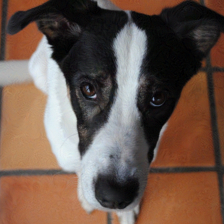

In [ ]:
print(f"Epsilon = 0.02, N = 6, prediction: minibus (99.98% confidence)")
to_pil_image(t_ifgsm_examples[0.02])

Now try the least-likely class method:

$$\begin{align*}
&y_\textit{LL}=\underset{y}{\arg\min}\ \Pr(y|\boldsymbol{X})\\
&\boldsymbol{X}_0^\textit{adv}=\boldsymbol{X} \\
&\boldsymbol{X}_{n+1}^\textit{adv}=\textit{Clip}_{\boldsymbol{X},\epsilon}\Big(\boldsymbol{X}_n^\textit{adv}-\alpha\text{sign}(\nabla_\boldsymbol{X}J(\boldsymbol{\theta},\boldsymbol{X}_n^\textit{adv},y_\textit{LL}))\Big)
\end{align*}$$

In [ ]:
epsilons = np.arange(0., 0.101, 0.005)
t_ifgsm_ll_examples = {}

for epsilon in epsilons:
    N = int(min(255 * epsilon + 4, 1.25 * 255 * epsilon))
    img_perturbed = t_ifgsm_attack(model, img, limpkin_index, epsilon, N)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, N = {}, classification result: {}".format(epsilon, N, new_top_1_class))
    if new_top_1_class[0] == 'limpkin':
        t_ifgsm_ll_examples[epsilon] = img_perturbed

Epsilon = 0.0, N = 0, classification result: ('Border Collie', 0.26453617)
Epsilon = 0.005, N = 1, classification result: ('Border Collie', 0.19821934)
Epsilon = 0.01, N = 3, classification result: ('Border Collie', 0.06024368)
Epsilon = 0.015, N = 4, classification result: ('limpkin', 0.40184233)
Epsilon = 0.02, N = 6, classification result: ('limpkin', 0.94280684)
Epsilon = 0.025, N = 7, classification result: ('limpkin', 0.9978847)
Epsilon = 0.03, N = 9, classification result: ('limpkin', 0.9997614)
Epsilon = 0.035, N = 11, classification result: ('limpkin', 0.99999976)
Epsilon = 0.04, N = 12, classification result: ('limpkin', 0.9999999)
Epsilon = 0.045, N = 14, classification result: ('limpkin', 1.0)
Epsilon = 0.05, N = 15, classification result: ('limpkin', 1.0)
Epsilon = 0.055, N = 17, classification result: ('limpkin', 1.0)
Epsilon = 0.06, N = 19, classification result: ('limpkin', 1.0)
Epsilon = 0.065, N = 20, classification result: ('limpkin', 1.0)
Epsilon = 0.07, N = 21, cla

The iterative least-likely class method provides a similar performance to a chosen class T-IFGSM attack (maybe slightly slower, but with no statistical significance). Therefore, one can choose arbitrary any class, and apply T-IFGSM attack to force ResNet-50 to classify an image to the chosen class, using a very small $\epsilon$ and number of iterations. T-IFGSM not only forces ResNet-50 to predict a target class, but also improves IFGSM's performance, in terms of the rate of convergence.

### Transferability to other neural networks

In this task I will try to apply the generated adversarial examples of the Blas image from the previous sections to ResNet-18 and VGG-19, to test whether those adversarial examples generated for ResNet-50 can keep fooling the other two networks.

#### ResNet-18

Firstly, output the the pretrained ResNet-18's predictions of the clean Blas image for baseline comparison:

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()
x = img_t.unsqueeze(0)
y = resnet18(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


[('Cardigan Welsh Corgi', 0.17196792),
 ('Staffordshire Bull Terrier', 0.16643907),
 ('American Staffordshire Terrier', 0.12468292),
 ('Great Dane', 0.10403946),
 ('Basenji', 0.094333336)]

It seems that ResNet-18 itself doesn't perform very well on the Blas image. Now apply the adversarial examples:

##### FGSM

In [ ]:
model = copy.deepcopy(resnet18)

for epsilon, adv_example in fgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.01, classification result: ('American Staffordshire Terrier', 0.27796578)
Epsilon = 0.02, classification result: ('American Staffordshire Terrier', 0.27308998)
Epsilon = 0.03, classification result: ('Boston Terrier', 0.45974553)
Epsilon = 0.04, classification result: ('Boston Terrier', 0.5088163)
Epsilon = 0.05, classification result: ('Boston Terrier', 0.33419433)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.20847873)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.16368799)
Epsilon = 0.08, classification result: ('Cardigan Welsh Corgi', 0.11687383)
Epsilon = 0.09, classification result: ('Beagle', 0.09880143)
Epsilon = 0.1, classification result: ('sock', 0.07862243)
Epsilon = 0.11, classification result: ('sock', 0.09133776)
Epsilon = 0.12, classification result: ('sock', 0.09066415)
Epsilon = 0.13, classification result: ('sock', 0.0905295)
Epsilon = 0.14, classification result: ('jigsaw puzzle', 0.07685062)
Epsilon = 0.15, classi

##### IFGSM

In [ ]:
for epsilon, adv_example in ifgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.005, classification result: ('American Staffordshire Terrier', 0.2402803)
Epsilon = 0.01, classification result: ('American Staffordshire Terrier', 0.29648963)
Epsilon = 0.015, classification result: ('American Staffordshire Terrier', 0.2908124)
Epsilon = 0.02, classification result: ('American Staffordshire Terrier', 0.35836452)
Epsilon = 0.025, classification result: ('Boston Terrier', 0.4135899)
Epsilon = 0.03, classification result: ('Boston Terrier', 0.2768695)
Epsilon = 0.035, classification result: ('Boston Terrier', 0.37776738)
Epsilon = 0.04, classification result: ('Boston Terrier', 0.2709977)
Epsilon = 0.045, classification result: ('Boston Terrier', 0.2571246)
Epsilon = 0.05, classification result: ('Boston Terrier', 0.3422215)
Epsilon = 0.055, classification result: ('Boston Terrier', 0.28429484)
Epsilon = 0.06, classification result: ('Boston Terrier', 0.38859218)
Epsilon = 0.065, classification result: ('Boston Terrier', 0.35725582)
Epsilon = 0.07, classifica

##### T-FGSM

In [ ]:
# Arbitrarily chosen class (minibus)
for epsilon, adv_example in t_fgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.17196792)
Epsilon = 0.01, classification result: ('Basenji', 0.30445087)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.42876548)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.63558275)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.44359618)
Epsilon = 0.05, classification result: ('ram', 0.30541384)
Epsilon = 0.06, classification result: ('Boston Terrier', 0.17965303)
Epsilon = 0.07, classification result: ('Boston Terrier', 0.09557182)
Epsilon = 0.08, classification result: ('bath towel', 0.09813595)
Epsilon = 0.09, classification result: ('sock', 0.23787792)
Epsilon = 0.1, classification result: ('sock', 0.39129686)
Epsilon = 0.11, classification result: ('sock', 0.41925037)
Epsilon = 0.12, classification result: ('sock', 0.41736117)
Epsilon = 0.13, classification result: ('sock', 0.3317394)
Epsilon = 0.14, classification result: ('sock', 0.2065281)
Epsilon = 0.

In [ ]:
# Least-likely class (limpkin)
for epsilon, adv_example in t_fgsm_ll_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.17196792)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.2061418)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.27939928)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.36879042)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.4224134)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.34472865)
Epsilon = 0.08, classification result: ('Cardigan Welsh Corgi', 0.19935389)
Epsilon = 0.09, classification result: ('Cardigan Welsh Corgi', 0.077869095)
Epsilon = 0.1, classification result: ('doormat', 0.09609228)
Epsilon = 0.11, classification result: ('jigsaw puzzle', 0.110281974)
Epsilon = 0.12, classification result: ('jigsaw puzzle', 0.14013481)
Epsilon = 0.13, classification result: ('prayer rug', 0.16789313)
Epsilon = 0.14, classification result: ('prayer rug', 0.2071519)
Epsilon = 0.15, classification result: ('prayer rug', 0.237284

##### T-IFGSM

In [ ]:
# Arbitrarily chosen class (minibus)
for epsilon, adv_example in t_ifgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.01, classification result: ('Cardigan Welsh Corgi', 0.33122304)
Epsilon = 0.015, classification result: ('Cardigan Welsh Corgi', 0.57603335)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.5429544)
Epsilon = 0.025, classification result: ('Cardigan Welsh Corgi', 0.45128968)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.3730991)
Epsilon = 0.035, classification result: ('Cardigan Welsh Corgi', 0.26070637)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.44920096)
Epsilon = 0.045, classification result: ('Boston Terrier', 0.22779942)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.42779845)
Epsilon = 0.055, classification result: ('Cardigan Welsh Corgi', 0.537192)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.3466673)
Epsilon = 0.065, classification result: ('Cardigan Welsh Corgi', 0.38310987)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.40744182)
Epsilon = 0.075, 

In [ ]:
# Least-likely class (limpkin)
for epsilon, adv_example in t_ifgsm_ll_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.015, classification result: ('Border Collie', 0.3330655)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.38735765)
Epsilon = 0.025, classification result: ('Cardigan Welsh Corgi', 0.37397715)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.43422866)
Epsilon = 0.035, classification result: ('Border Collie', 0.3873082)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.3646098)
Epsilon = 0.045, classification result: ('Cardigan Welsh Corgi', 0.52410537)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.4220839)
Epsilon = 0.055, classification result: ('Cardigan Welsh Corgi', 0.3724855)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.3714623)
Epsilon = 0.065, classification result: ('Cardigan Welsh Corgi', 0.5388215)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.40003026)
Epsilon = 0.075, classification result: ('Cardigan Welsh Corgi', 0.5621043)
Epsilon = 0.08, classificat

#### VGG-19

Firstly, output the the pretrained VGG-19's predictions of the clean Blas image for baseline comparison:

In [ ]:
vgg19 = models.vgg19(pretrained=True)
vgg19.eval()
x = img_t.unsqueeze(0)
y = vgg19(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


[('Cardigan Welsh Corgi', 0.67670065),
 ('Basenji', 0.12864792),
 ('Whippet', 0.117506735),
 ('Border Collie', 0.03454853),
 ('collie', 0.014183084)]

VGG-19 also misclassifies Blas as a Cardigan Welsh Corgi. Now apply the adversarial examples:

##### FGSM

In [ ]:
model = copy.deepcopy(vgg19)

for epsilon, adv_example in fgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.01, classification result: ('Whippet', 0.41596705)
Epsilon = 0.02, classification result: ('Whippet', 0.27976453)
Epsilon = 0.03, classification result: ('American Staffordshire Terrier', 0.24490355)
Epsilon = 0.04, classification result: ('American Staffordshire Terrier', 0.24139568)
Epsilon = 0.05, classification result: ('American Staffordshire Terrier', 0.1942436)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.2704513)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.31577024)
Epsilon = 0.08, classification result: ('Cardigan Welsh Corgi', 0.3303616)
Epsilon = 0.09, classification result: ('Cardigan Welsh Corgi', 0.2862867)
Epsilon = 0.1, classification result: ('Cardigan Welsh Corgi', 0.19737765)
Epsilon = 0.11, classification result: ('Cardigan Welsh Corgi', 0.09961331)
Epsilon = 0.12, classification result: ('Standard Poodle', 0.08897782)
Epsilon = 0.13, classification result: ('Standard Poodle', 0.11245746)
Epsilon = 0.14, classif

##### IFGSM

In [ ]:
for epsilon, adv_example in ifgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.005, classification result: ('Whippet', 0.46615395)
Epsilon = 0.01, classification result: ('Cardigan Welsh Corgi', 0.50600475)
Epsilon = 0.015, classification result: ('Cardigan Welsh Corgi', 0.42505473)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.4291764)
Epsilon = 0.025, classification result: ('Cardigan Welsh Corgi', 0.26675525)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.6213276)
Epsilon = 0.035, classification result: ('Cardigan Welsh Corgi', 0.23873043)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.31849933)
Epsilon = 0.045, classification result: ('Cardigan Welsh Corgi', 0.29283097)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.39039063)
Epsilon = 0.055, classification result: ('Cardigan Welsh Corgi', 0.25329593)
Epsilon = 0.06, classification result: ('Whippet', 0.19036071)
Epsilon = 0.065, classification result: ('Cardigan Welsh Corgi', 0.39504516)
Epsilon = 0.07, classification re

##### T-FGSM

In [ ]:
# Arbitrarily chosen class (minibus)
for epsilon, adv_example in t_fgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.67670065)
Epsilon = 0.01, classification result: ('Cardigan Welsh Corgi', 0.9154575)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.9469944)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.76725036)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.511191)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.30348304)
Epsilon = 0.06, classification result: ('Shetland Sheepdog', 0.20369838)
Epsilon = 0.07, classification result: ('Shetland Sheepdog', 0.14373627)
Epsilon = 0.08, classification result: ('Standard Poodle', 0.30412212)
Epsilon = 0.09, classification result: ('Standard Poodle', 0.39750767)
Epsilon = 0.1, classification result: ('Standard Poodle', 0.39006433)
Epsilon = 0.11, classification result: ('Standard Poodle', 0.36328086)
Epsilon = 0.12, classification result: ('Standard Poodle', 0.3157587)
Epsilon = 0.13, classification result: ('Standard 

In [ ]:
# Least-likely class (limpkin)
for epsilon, adv_example in t_fgsm_ll_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.0, classification result: ('Cardigan Welsh Corgi', 0.67670065)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.68746036)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.690147)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.53263944)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.33855966)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.19841476)
Epsilon = 0.08, classification result: ('Cardigan Welsh Corgi', 0.11808061)
Epsilon = 0.09, classification result: ('Shetland Sheepdog', 0.067709364)
Epsilon = 0.1, classification result: ('Shetland Sheepdog', 0.05186452)
Epsilon = 0.11, classification result: ('Standard Poodle', 0.088371105)
Epsilon = 0.12, classification result: ('Standard Poodle', 0.10916776)
Epsilon = 0.13, classification result: ('Standard Poodle', 0.10271077)
Epsilon = 0.14, classification result: ('Standard Poodle', 0.08938697)
Epsilon = 0.15, classification result: (

##### T-IFGSM

In [ ]:
# Arbitrarily chosen class (minibus)
for epsilon, adv_example in t_ifgsm_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.01, classification result: ('Cardigan Welsh Corgi', 0.9627101)
Epsilon = 0.015, classification result: ('Cardigan Welsh Corgi', 0.9313812)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.97616243)
Epsilon = 0.025, classification result: ('Cardigan Welsh Corgi', 0.9582523)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.9788341)
Epsilon = 0.035, classification result: ('Cardigan Welsh Corgi', 0.97665477)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.97857976)
Epsilon = 0.045, classification result: ('Cardigan Welsh Corgi', 0.970834)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.9817152)
Epsilon = 0.055, classification result: ('Cardigan Welsh Corgi', 0.89917034)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.9344593)
Epsilon = 0.065, classification result: ('Cardigan Welsh Corgi', 0.9598572)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.95788914)
Epsilon = 0.075

In [ ]:
# Least-likely class (limpkin)
for epsilon, adv_example in t_ifgsm_ll_examples.items():
    x_perturbed = normalise(adv_example).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))

Epsilon = 0.015, classification result: ('Cardigan Welsh Corgi', 0.6493105)
Epsilon = 0.02, classification result: ('Cardigan Welsh Corgi', 0.902762)
Epsilon = 0.025, classification result: ('Cardigan Welsh Corgi', 0.856208)
Epsilon = 0.03, classification result: ('Cardigan Welsh Corgi', 0.87741643)
Epsilon = 0.035, classification result: ('Cardigan Welsh Corgi', 0.8264565)
Epsilon = 0.04, classification result: ('Cardigan Welsh Corgi', 0.8823729)
Epsilon = 0.045, classification result: ('Cardigan Welsh Corgi', 0.76737547)
Epsilon = 0.05, classification result: ('Cardigan Welsh Corgi', 0.9347998)
Epsilon = 0.055, classification result: ('Cardigan Welsh Corgi', 0.8900476)
Epsilon = 0.06, classification result: ('Cardigan Welsh Corgi', 0.82747)
Epsilon = 0.065, classification result: ('Cardigan Welsh Corgi', 0.964055)
Epsilon = 0.07, classification result: ('Cardigan Welsh Corgi', 0.9395568)
Epsilon = 0.075, classification result: ('Cardigan Welsh Corgi', 0.94301873)
Epsilon = 0.08, clas

#### Summary

* In ResNet-18, FGSM and T-FGSM become more effective than originally in ResNet-50, whereas in VGG-19, FGSM and T-FGSM become less effective;
* Both in ResNet-18 and VGG-19, T-FGSM is still an improvement compared to FGSM;
* Both in ResNet-18 and VGG-19, IFGSM and T-IFGSM completely lose the ability to fool the neural networks (they even increased the neural networks' top-1 class confidence!)
* The reason that one-shot FGSMs can maintain transferability while iterative FGSMs are incapable to transfer to other neural networks can be that the iterative FGSMs tend to overfit to the particular model in iteratively calculating the gradients, whereas the underfitting nature of the one-shot FGSMs become their merits when it comes to transferability. 

### Transferability to other images

Here is a photo of my cat Leo. In this task, I will test whether the perturbations generated for the Blas image using the above methods added to this image can still fool the neural networks:  

In [ ]:
!wget https://i.imgur.com/LYceL25.jpeg -O leo.jpeg

--2021-03-14 00:23:51--  https://i.imgur.com/LYceL25.jpeg
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114749 (112K) [image/jpeg]
Saving to: ‘leo.jpeg’

leo.jpeg            100%[===================>] 112.06K  --.-KB/s    in 0.01s   

2021-03-14 00:23:51 (7.90 MB/s) - ‘leo.jpeg’ saved [114749/114749]



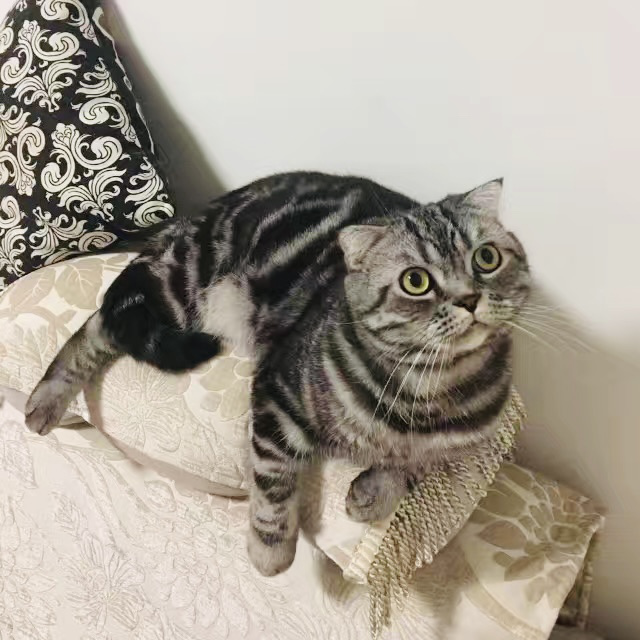

In [ ]:
img_leo = Image.open('leo.jpeg')
img_leo

Firstly, transform the original image and see the neural networks' outputs on the clean input:

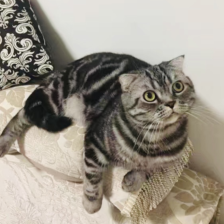

In [ ]:
to_pil_image(transform(img_leo))

In [ ]:
x = normalise(transform(img_leo)).unsqueeze(0)
y = resnet50(x)
top_5_classes(y)

[('tabby cat', 0.743952),
 ('Egyptian Mau', 0.07621425),
 ('tiger cat', 0.06798427),
 ('velvet', 0.016252333),
 ('quilt', 0.0055693104)]

In [ ]:
y = resnet18(x)
top_5_classes(y)

[('tabby cat', 0.13486396),
 ('Egyptian Mau', 0.04983853),
 ('plastic bag', 0.04013484),
 ('paper towel', 0.037175372),
 ('tiger cat', 0.029757576)]

In [ ]:
y = vgg19(x)
top_5_classes(y)

[('tabby cat', 0.7847225),
 ('tiger cat', 0.084127635),
 ('Egyptian Mau', 0.062015504),
 ('paper towel', 0.009401048),
 ('quilt', 0.006365612)]

Leo is actually an American Shorthair, but it seems that this class is not included in the ImageNet, so I will forgive the neural network for this time... It is also worth noting that although ResNet-18 classifies Leo as a tabby cat same as ResNet-50 and VGG-19, it outputs it with a much lower confidence compared to the other two neural networks.

Now rebuild the perturbations for the Blas image with the previously used methods, add them to the Leo image, and see the neural networks' predictions:

#### FGSM

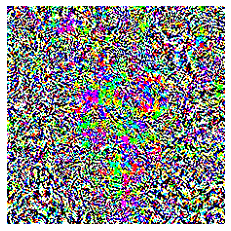

In [ ]:
gradient_sign = get_gradient_sign(resnet50, transform(img), border_collie_index)
plt.imshow(np.moveaxis(gradient_sign, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

##### ResNet-50

In [ ]:
model = copy.deepcopy(resnet50)
epsilons = np.arange(0., 0.301, 0.01)
fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.743952)
Epsilon = 0.01, classification result: ('tabby cat', 0.7080742)
Epsilon = 0.02, classification result: ('tabby cat', 0.80317)
Epsilon = 0.03, classification result: ('tabby cat', 0.857727)
Epsilon = 0.04, classification result: ('tabby cat', 0.86449176)
Epsilon = 0.05, classification result: ('tabby cat', 0.8359511)
Epsilon = 0.06, classification result: ('tabby cat', 0.7906913)
Epsilon = 0.07, classification result: ('tabby cat', 0.73963267)
Epsilon = 0.08, classification result: ('tabby cat', 0.6911621)
Epsilon = 0.09, classification result: ('tabby cat', 0.58298826)
Epsilon = 0.1, classification result: ('tabby cat', 0.3717871)
Epsilon = 0.11, classification result: ('pug', 0.4583637)
Epsilon = 0.12, classification result: ('pug', 0.712625)
Epsilon = 0.13, classification result: ('pug', 0.7882861)
Epsilon = 0.14, classification result: ('pug', 0.78362197)
Epsilon = 0.15, classification result: ('pug', 0.74720925)
Epsilon 

The outcome is even better than on the Blas image itself! ResNet-50 starts to think that Leo is a dog with high confidence at $0.1<\epsilon\leq0.2$, and recognises him to be some object at $\epsilon>0.2$ (this time not as confident, but still better than the Blas image's outcomes). Let's view the perturbed image with $\epsilon=0.11$, where ResNet-50 classifies Leo as a pug dog, with confidence 0.46:

Epsilon = 0.11, prediction: pug (45.84% confidence)


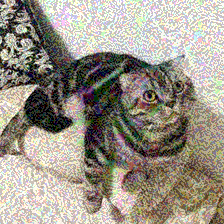

In [ ]:
print(f"Epsilon = 0.11, prediction: pug (45.84% confidence)")
to_pil_image(fgsm_examples_leo[0.11])

Now do the same to ResNet-18 and VGG-19:

##### ResNet-18

In [ ]:
model = copy.deepcopy(resnet18)
epsilons = np.arange(0., 0.301, 0.01)
fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.13486396)
Epsilon = 0.01, classification result: ('tabby cat', 0.13153978)
Epsilon = 0.02, classification result: ('tabby cat', 0.21163799)
Epsilon = 0.03, classification result: ('tabby cat', 0.39082873)
Epsilon = 0.04, classification result: ('tabby cat', 0.528667)
Epsilon = 0.05, classification result: ('tabby cat', 0.62456125)
Epsilon = 0.06, classification result: ('tabby cat', 0.6831472)
Epsilon = 0.07, classification result: ('tabby cat', 0.68352455)
Epsilon = 0.08, classification result: ('tabby cat', 0.65069103)
Epsilon = 0.09, classification result: ('tabby cat', 0.55013984)
Epsilon = 0.1, classification result: ('tabby cat', 0.42155698)
Epsilon = 0.11, classification result: ('tabby cat', 0.27988803)
Epsilon = 0.12, classification result: ('green iguana', 0.1809507)
Epsilon = 0.13, classification result: ('green iguana', 0.15486225)
Epsilon = 0.14, classification result: ('green iguana', 0.0962778)
Epsilon = 0.15, classif

Epsilon = 0.12, prediction: green iguana (18.10% confidence)


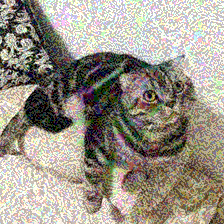

In [ ]:
print(f"Epsilon = 0.12, prediction: green iguana (18.10% confidence)")
to_pil_image(fgsm_examples_leo[0.12])

##### VGG-19

In [ ]:
model = copy.deepcopy(vgg19)
epsilons = np.arange(0., 0.301, 0.01)
fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.7847225)
Epsilon = 0.01, classification result: ('tabby cat', 0.7314201)
Epsilon = 0.02, classification result: ('tabby cat', 0.7540944)
Epsilon = 0.03, classification result: ('tabby cat', 0.7538929)
Epsilon = 0.04, classification result: ('tabby cat', 0.75736403)
Epsilon = 0.05, classification result: ('tabby cat', 0.7374005)
Epsilon = 0.06, classification result: ('tabby cat', 0.6963148)
Epsilon = 0.07, classification result: ('tabby cat', 0.6749427)
Epsilon = 0.08, classification result: ('tabby cat', 0.6395525)
Epsilon = 0.09, classification result: ('tabby cat', 0.511365)
Epsilon = 0.1, classification result: ('tabby cat', 0.2538326)
Epsilon = 0.11, classification result: ('tabby cat', 0.08713198)
Epsilon = 0.12, classification result: ('chameleon', 0.053798318)
Epsilon = 0.13, classification result: ('Scottish Terrier', 0.051645316)
Epsilon = 0.14, classification result: ('Scottish Terrier', 0.0695155)
Epsilon = 0.15, classif

Epsilon = 0.12, prediction: chameleon (5.38% confidence)


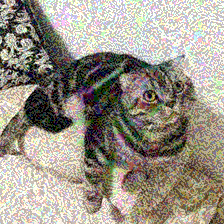

In [ ]:
print(f"Epsilon = 0.12, prediction: chameleon (5.38% confidence)")
to_pil_image(fgsm_examples_leo[0.12])

They all produced similar outcomes.

#### IFGSM

Since IFGSM recalculates the gradients on every iteration, it would be inappropriate to simply rerun the IFGSM attack on the Leo image as before, as this would be calculating the grainents of the Leo image, rather than the Blas image as intended. Instead, I will extract adversarial examples of the Blas image generated by IFGSM, and calculate the differences between they and the the clean Blas image to retrieve the overall gradients, which can be then added to the Leo image, for example:

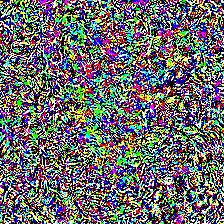

In [ ]:
perturbation = ifgsm_examples[0.065] - transform(img)
to_pil_image(perturbation)

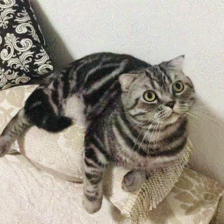

In [ ]:
img_leo_perturbed = transform(img_leo) + perturbation
img_leo_perturbed = torch.clamp(img_leo_perturbed, 0, 1)

to_pil_image(img_leo_perturbed)

Now apply this method to all the adversarial examples I have obtained in the IFGSM experiment:

##### ResNet-50

In [ ]:
model = copy.deepcopy(resnet50)
ifgsm_examples_leo = {}

for epsilon, adv_example in ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.005, classification result: ('tabby cat', 0.68855256)
Epsilon = 0.01, classification result: ('tabby cat', 0.7214255)
Epsilon = 0.015, classification result: ('tabby cat', 0.7074406)
Epsilon = 0.02, classification result: ('tabby cat', 0.7422437)
Epsilon = 0.025, classification result: ('tabby cat', 0.7143906)
Epsilon = 0.03, classification result: ('tabby cat', 0.74221563)
Epsilon = 0.035, classification result: ('tabby cat', 0.71217513)
Epsilon = 0.04, classification result: ('tabby cat', 0.7534252)
Epsilon = 0.045, classification result: ('tabby cat', 0.675075)
Epsilon = 0.05, classification result: ('tabby cat', 0.7723808)
Epsilon = 0.055, classification result: ('tabby cat', 0.6710334)
Epsilon = 0.06, classification result: ('tabby cat', 0.7385005)
Epsilon = 0.065, classification result: ('tabby cat', 0.7196398)
Epsilon = 0.07, classification result: ('tabby cat', 0.7787123)
Epsilon = 0.075, classification result: ('tabby cat', 0.7283474)
Epsilon = 0.08, classification

##### ResNet-18

In [ ]:
model = copy.deepcopy(resnet18)
ifgsm_examples_leo = {}

for epsilon, adv_example in ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.005, classification result: ('tabby cat', 0.12616287)
Epsilon = 0.01, classification result: ('tabby cat', 0.13911512)
Epsilon = 0.015, classification result: ('tabby cat', 0.16009429)
Epsilon = 0.02, classification result: ('tabby cat', 0.16270103)
Epsilon = 0.025, classification result: ('tabby cat', 0.17210853)
Epsilon = 0.03, classification result: ('tabby cat', 0.18330741)
Epsilon = 0.035, classification result: ('tabby cat', 0.19444774)
Epsilon = 0.04, classification result: ('tabby cat', 0.23284404)
Epsilon = 0.045, classification result: ('tabby cat', 0.17579186)
Epsilon = 0.05, classification result: ('tabby cat', 0.24119559)
Epsilon = 0.055, classification result: ('tabby cat', 0.20825091)
Epsilon = 0.06, classification result: ('tabby cat', 0.27483442)
Epsilon = 0.065, classification result: ('tabby cat', 0.19190587)
Epsilon = 0.07, classification result: ('tabby cat', 0.24168628)
Epsilon = 0.075, classification result: ('tabby cat', 0.30816987)
Epsilon = 0.08, c

##### VGG-19

In [ ]:
model = copy.deepcopy(vgg19)
ifgsm_examples_leo = {}

for epsilon, adv_example in ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.005, classification result: ('tabby cat', 0.718797)
Epsilon = 0.01, classification result: ('tabby cat', 0.6991113)
Epsilon = 0.015, classification result: ('tabby cat', 0.7052332)
Epsilon = 0.02, classification result: ('tabby cat', 0.69521374)
Epsilon = 0.025, classification result: ('tabby cat', 0.70487666)
Epsilon = 0.03, classification result: ('tabby cat', 0.6804088)
Epsilon = 0.035, classification result: ('tabby cat', 0.67911553)
Epsilon = 0.04, classification result: ('tabby cat', 0.69804466)
Epsilon = 0.045, classification result: ('tabby cat', 0.6998114)
Epsilon = 0.05, classification result: ('tabby cat', 0.7014868)
Epsilon = 0.055, classification result: ('tabby cat', 0.6826002)
Epsilon = 0.06, classification result: ('tabby cat', 0.7066339)
Epsilon = 0.065, classification result: ('tabby cat', 0.67731)
Epsilon = 0.07, classification result: ('tabby cat', 0.706453)
Epsilon = 0.075, classification result: ('tabby cat', 0.7240012)
Epsilon = 0.08, classification r

IFGSM still cannot fool the neural networks (it even increased VGG-19's confidence in its top-1 prediction...)

#### T-FGSM

T-FGSM can be done similarly to FGSM. It is worth pointing out that least-likely class for the Blas image may not also be the least-likely class for the Leo image, so the limpkin class in here is no more special than the minibus class in the view of the Leo image. Since both gradients have been calculated before, there is no harm trying both of them here:

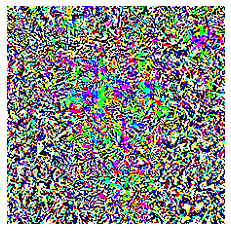

In [ ]:
# Minibus
gradient_sign_minibus = get_gradient_sign(resnet50, transform(img), minibus_index)
plt.imshow(np.moveaxis(gradient_sign_minibus, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

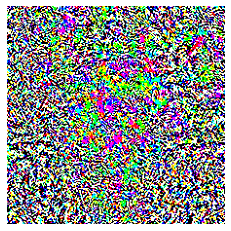

In [ ]:
# Limpkin
gradient_sign_limpkin = get_gradient_sign(resnet50, transform(img), limpkin_index)
plt.imshow(np.moveaxis(gradient_sign_limpkin, 0, -1) * 0.5 + 0.5)  # To change the range from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

##### ResNet-50

In [ ]:
# Minibus
model = copy.deepcopy(resnet50)
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_minibus, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.743952)
Epsilon = 0.01, classification result: ('tabby cat', 0.7421274)
Epsilon = 0.02, classification result: ('tabby cat', 0.85729235)
Epsilon = 0.03, classification result: ('tabby cat', 0.91010946)
Epsilon = 0.04, classification result: ('tabby cat', 0.9138076)
Epsilon = 0.05, classification result: ('tabby cat', 0.90369445)
Epsilon = 0.06, classification result: ('tabby cat', 0.89966404)
Epsilon = 0.07, classification result: ('tabby cat', 0.89249617)
Epsilon = 0.08, classification result: ('tabby cat', 0.83909833)
Epsilon = 0.09, classification result: ('tabby cat', 0.724836)
Epsilon = 0.1, classification result: ('tabby cat', 0.6439547)
Epsilon = 0.11, classification result: ('tabby cat', 0.49823517)
Epsilon = 0.12, classification result: ('tabby cat', 0.35589942)
Epsilon = 0.13, classification result: ('tabby cat', 0.21038106)
Epsilon = 0.14, classification result: ('pug', 0.26608816)
Epsilon = 0.15, classification result: (

Epsilon = 0.14, prediction: pug (26.61% confidence)


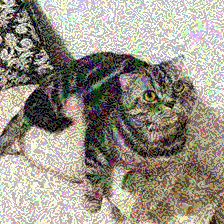

In [ ]:
print(f"Epsilon = 0.14, prediction: pug (26.61% confidence)")
to_pil_image(t_fgsm_examples_leo[0.14])

In [ ]:
# Limpkin
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_limpkin, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.743952)
Epsilon = 0.01, classification result: ('tabby cat', 0.7567326)
Epsilon = 0.02, classification result: ('tabby cat', 0.85477597)
Epsilon = 0.03, classification result: ('tabby cat', 0.8901807)
Epsilon = 0.04, classification result: ('tabby cat', 0.8903892)
Epsilon = 0.05, classification result: ('tabby cat', 0.8692233)
Epsilon = 0.06, classification result: ('tabby cat', 0.8320199)
Epsilon = 0.07, classification result: ('tabby cat', 0.7821968)
Epsilon = 0.08, classification result: ('tabby cat', 0.7421792)
Epsilon = 0.09, classification result: ('tabby cat', 0.6975142)
Epsilon = 0.1, classification result: ('tabby cat', 0.65001404)
Epsilon = 0.11, classification result: ('tabby cat', 0.6729371)
Epsilon = 0.12, classification result: ('tabby cat', 0.70585376)
Epsilon = 0.13, classification result: ('tabby cat', 0.7285512)
Epsilon = 0.14, classification result: ('tabby cat', 0.6525558)
Epsilon = 0.15, classification result: (

Epsilon = 0.18, prediction: screw (5.59% confidence)


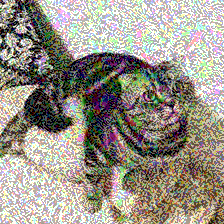

In [ ]:
print(f"Epsilon = 0.18, prediction: screw (5.59% confidence)")
to_pil_image(t_fgsm_examples_leo[0.18])

##### ResNet-18

In [ ]:
# Minibus
model = copy.deepcopy(resnet18)
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_minibus, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.13486396)
Epsilon = 0.01, classification result: ('tabby cat', 0.22665443)
Epsilon = 0.02, classification result: ('tabby cat', 0.49082595)
Epsilon = 0.03, classification result: ('tabby cat', 0.6064507)
Epsilon = 0.04, classification result: ('tabby cat', 0.67190605)
Epsilon = 0.05, classification result: ('tabby cat', 0.72483224)
Epsilon = 0.06, classification result: ('tabby cat', 0.7694333)
Epsilon = 0.07, classification result: ('tabby cat', 0.8024848)
Epsilon = 0.08, classification result: ('tabby cat', 0.8425718)
Epsilon = 0.09, classification result: ('tabby cat', 0.85782796)
Epsilon = 0.1, classification result: ('tabby cat', 0.8605604)
Epsilon = 0.11, classification result: ('tabby cat', 0.8223088)
Epsilon = 0.12, classification result: ('tabby cat', 0.7041272)
Epsilon = 0.13, classification result: ('tabby cat', 0.4619011)
Epsilon = 0.14, classification result: ('tabby cat', 0.22887039)
Epsilon = 0.15, classification resu

Epsilon = 0.15, prediction: American alligator (14.32% confidence)


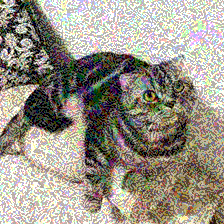

In [ ]:
print(f"Epsilon = 0.15, prediction: American alligator (14.32% confidence)")
to_pil_image(t_fgsm_examples_leo[0.15])

In [ ]:
# Limpkin
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_limpkin, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.13486396)
Epsilon = 0.01, classification result: ('tabby cat', 0.18017837)
Epsilon = 0.02, classification result: ('tabby cat', 0.25829402)
Epsilon = 0.03, classification result: ('tabby cat', 0.3571602)
Epsilon = 0.04, classification result: ('tabby cat', 0.5057435)
Epsilon = 0.05, classification result: ('tabby cat', 0.66333514)
Epsilon = 0.06, classification result: ('tabby cat', 0.7607208)
Epsilon = 0.07, classification result: ('tabby cat', 0.81064284)
Epsilon = 0.08, classification result: ('tabby cat', 0.8249281)
Epsilon = 0.09, classification result: ('tabby cat', 0.8306055)
Epsilon = 0.1, classification result: ('tabby cat', 0.82716626)
Epsilon = 0.11, classification result: ('tabby cat', 0.77091956)
Epsilon = 0.12, classification result: ('tabby cat', 0.64515203)
Epsilon = 0.13, classification result: ('tabby cat', 0.48452133)
Epsilon = 0.14, classification result: ('tabby cat', 0.24057561)
Epsilon = 0.15, classification r

Epsilon = 0.15, prediction: jigsaw puzzle (14.77% confidence)


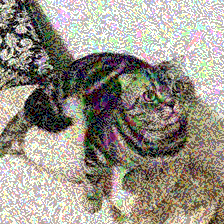

In [ ]:
print(f"Epsilon = 0.15, prediction: jigsaw puzzle (14.77% confidence)")
to_pil_image(t_fgsm_examples_leo[0.15])

##### VGG-19

In [ ]:
# Minibus
model = copy.deepcopy(vgg19)
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_minibus, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.7847225)
Epsilon = 0.01, classification result: ('tabby cat', 0.76438147)
Epsilon = 0.02, classification result: ('tabby cat', 0.7848924)
Epsilon = 0.03, classification result: ('tabby cat', 0.80042535)
Epsilon = 0.04, classification result: ('tabby cat', 0.7938831)
Epsilon = 0.05, classification result: ('tabby cat', 0.74242014)
Epsilon = 0.06, classification result: ('tabby cat', 0.6955584)
Epsilon = 0.07, classification result: ('tabby cat', 0.6630861)
Epsilon = 0.08, classification result: ('tabby cat', 0.5694517)
Epsilon = 0.09, classification result: ('tabby cat', 0.4193746)
Epsilon = 0.1, classification result: ('tabby cat', 0.2988397)
Epsilon = 0.11, classification result: ('great grey owl', 0.18752207)
Epsilon = 0.12, classification result: ('great grey owl', 0.19763422)
Epsilon = 0.13, classification result: ('great grey owl', 0.17208709)
Epsilon = 0.14, classification result: ('great grey owl', 0.112597905)
Epsilon = 0.15

Epsilon = 0.11, prediction: great grey owl (18.75% confidence)


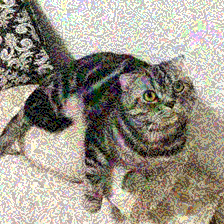

In [ ]:
print(f"Epsilon = 0.11, prediction: great grey owl (18.75% confidence)")
to_pil_image(t_fgsm_examples_leo[0.11])

In [ ]:
# Limpkin
epsilons = np.arange(0., 0.301, 0.01)
t_fgsm_examples_leo = {}

for epsilon in epsilons:
    img_perturbed = fgsm_attack(img_leo, gradient_sign_limpkin, epsilon)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_fgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.0, classification result: ('tabby cat', 0.7847225)
Epsilon = 0.01, classification result: ('tabby cat', 0.6827876)
Epsilon = 0.02, classification result: ('tabby cat', 0.7292569)
Epsilon = 0.03, classification result: ('tabby cat', 0.7351548)
Epsilon = 0.04, classification result: ('tabby cat', 0.72962546)
Epsilon = 0.05, classification result: ('tabby cat', 0.7280214)
Epsilon = 0.06, classification result: ('tabby cat', 0.7070535)
Epsilon = 0.07, classification result: ('tabby cat', 0.65601695)
Epsilon = 0.08, classification result: ('tabby cat', 0.5536294)
Epsilon = 0.09, classification result: ('tabby cat', 0.38956535)
Epsilon = 0.1, classification result: ('tabby cat', 0.21238504)
Epsilon = 0.11, classification result: ('doormat', 0.11639829)
Epsilon = 0.12, classification result: ('maze', 0.16311622)
Epsilon = 0.13, classification result: ('maze', 0.33915183)
Epsilon = 0.14, classification result: ('maze', 0.37742147)
Epsilon = 0.15, classification result: ('maze', 0.3

Epsilon = 0.11, prediction: doormat (11.64% confidence)


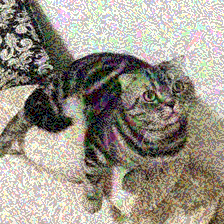

In [ ]:
print(f"Epsilon = 0.11, prediction: doormat (11.64% confidence)")
to_pil_image(t_fgsm_examples_leo[0.11])

Summary:

* T-FGSM perturbations on the Blas image added to the Leo image still cannot force the neural networks to predict the desired class;
* This time, T-FGSM is no longer an improvement compared to the untargeted FGSM. A possible explanation is that if we intrpret the perturbation as a movement vector along the loss function, then the movement vector optimised for the Blas image will not be necessarily as effective when applied to the Leo image, which is at a different location in the loss function.

#### T-IFGSM

T-IFGSM can be done similarly to IFGSM. Again, I will try both classes used in the Blas experiment:

##### ResNet-50

In [ ]:
model = copy.deepcopy(resnet50)
t_ifgsm_examples_leo = {}

for epsilon, adv_example in t_ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.01, classification result: ('tabby cat', 0.69212836)
Epsilon = 0.015, classification result: ('tabby cat', 0.71052164)
Epsilon = 0.02, classification result: ('tabby cat', 0.7438756)
Epsilon = 0.025, classification result: ('tabby cat', 0.7309189)
Epsilon = 0.03, classification result: ('tabby cat', 0.7060366)
Epsilon = 0.035, classification result: ('tabby cat', 0.7214355)
Epsilon = 0.04, classification result: ('tabby cat', 0.6922819)
Epsilon = 0.045, classification result: ('tabby cat', 0.7476684)
Epsilon = 0.05, classification result: ('tabby cat', 0.68147177)
Epsilon = 0.055, classification result: ('tabby cat', 0.7274903)
Epsilon = 0.06, classification result: ('tabby cat', 0.7354726)
Epsilon = 0.065, classification result: ('tabby cat', 0.7583162)
Epsilon = 0.07, classification result: ('tabby cat', 0.71672934)
Epsilon = 0.075, classification result: ('tabby cat', 0.81983644)
Epsilon = 0.08, classification result: ('tabby cat', 0.7251003)
Epsilon = 0.085, classificat

In [ ]:
t_ifgsm_ll_examples_leo = {}

for epsilon, adv_example in t_ifgsm_ll_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_ll_examples_leo[epsilon] = img_perturbed

Epsilon = 0.015, classification result: ('tabby cat', 0.72985476)
Epsilon = 0.02, classification result: ('tabby cat', 0.7042841)
Epsilon = 0.025, classification result: ('tabby cat', 0.69304854)
Epsilon = 0.03, classification result: ('tabby cat', 0.70128155)
Epsilon = 0.035, classification result: ('tabby cat', 0.7224179)
Epsilon = 0.04, classification result: ('tabby cat', 0.7206531)
Epsilon = 0.045, classification result: ('tabby cat', 0.706441)
Epsilon = 0.05, classification result: ('tabby cat', 0.7072288)
Epsilon = 0.055, classification result: ('tabby cat', 0.71581155)
Epsilon = 0.06, classification result: ('tabby cat', 0.7954281)
Epsilon = 0.065, classification result: ('tabby cat', 0.72510797)
Epsilon = 0.07, classification result: ('tabby cat', 0.7274485)
Epsilon = 0.075, classification result: ('tabby cat', 0.73070353)
Epsilon = 0.08, classification result: ('tabby cat', 0.7390287)
Epsilon = 0.085, classification result: ('tabby cat', 0.73380655)
Epsilon = 0.09, classifica

##### ResNet-18

In [ ]:
model = copy.deepcopy(resnet18)
t_ifgsm_examples_leo = {}

for epsilon, adv_example in t_ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.01, classification result: ('tabby cat', 0.15968)
Epsilon = 0.015, classification result: ('tabby cat', 0.20331997)
Epsilon = 0.02, classification result: ('tabby cat', 0.21391897)
Epsilon = 0.025, classification result: ('tabby cat', 0.22003569)
Epsilon = 0.03, classification result: ('tabby cat', 0.2034834)
Epsilon = 0.035, classification result: ('tabby cat', 0.19469082)
Epsilon = 0.04, classification result: ('tabby cat', 0.19954345)
Epsilon = 0.045, classification result: ('tabby cat', 0.20217007)
Epsilon = 0.05, classification result: ('tabby cat', 0.1808343)
Epsilon = 0.055, classification result: ('tabby cat', 0.23622474)
Epsilon = 0.06, classification result: ('tabby cat', 0.20989516)
Epsilon = 0.065, classification result: ('tabby cat', 0.21629861)
Epsilon = 0.07, classification result: ('tabby cat', 0.19317411)
Epsilon = 0.075, classification result: ('tabby cat', 0.24685413)
Epsilon = 0.08, classification result: ('tabby cat', 0.17731316)
Epsilon = 0.085, classi

In [ ]:
t_ifgsm_ll_examples_leo = {}

for epsilon, adv_example in t_ifgsm_ll_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_ll_examples_leo[epsilon] = img_perturbed

Epsilon = 0.015, classification result: ('tabby cat', 0.14715841)
Epsilon = 0.02, classification result: ('tabby cat', 0.17654252)
Epsilon = 0.025, classification result: ('tabby cat', 0.20678516)
Epsilon = 0.03, classification result: ('tabby cat', 0.22141932)
Epsilon = 0.035, classification result: ('tabby cat', 0.17802267)
Epsilon = 0.04, classification result: ('tabby cat', 0.25844523)
Epsilon = 0.045, classification result: ('tabby cat', 0.2345567)
Epsilon = 0.05, classification result: ('tabby cat', 0.28236926)
Epsilon = 0.055, classification result: ('tabby cat', 0.30662283)
Epsilon = 0.06, classification result: ('tabby cat', 0.2786972)
Epsilon = 0.065, classification result: ('tabby cat', 0.32170644)
Epsilon = 0.07, classification result: ('tabby cat', 0.26280546)
Epsilon = 0.075, classification result: ('tabby cat', 0.34921455)
Epsilon = 0.08, classification result: ('tabby cat', 0.26380157)
Epsilon = 0.085, classification result: ('tabby cat', 0.3746234)
Epsilon = 0.09, clas

##### VGG-19

In [ ]:
model = copy.deepcopy(vgg19)
t_ifgsm_examples_leo = {}

for epsilon, adv_example in t_ifgsm_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_examples_leo[epsilon] = img_perturbed

Epsilon = 0.01, classification result: ('tabby cat', 0.68997324)
Epsilon = 0.015, classification result: ('tabby cat', 0.6713647)
Epsilon = 0.02, classification result: ('tabby cat', 0.6728082)
Epsilon = 0.025, classification result: ('tabby cat', 0.6794968)
Epsilon = 0.03, classification result: ('tabby cat', 0.6805133)
Epsilon = 0.035, classification result: ('tabby cat', 0.7074259)
Epsilon = 0.04, classification result: ('tabby cat', 0.6798966)
Epsilon = 0.045, classification result: ('tabby cat', 0.693656)
Epsilon = 0.05, classification result: ('tabby cat', 0.6668405)
Epsilon = 0.055, classification result: ('tabby cat', 0.67750204)
Epsilon = 0.06, classification result: ('tabby cat', 0.71021885)
Epsilon = 0.065, classification result: ('tabby cat', 0.6798894)
Epsilon = 0.07, classification result: ('tabby cat', 0.6880294)
Epsilon = 0.075, classification result: ('tabby cat', 0.6961807)
Epsilon = 0.08, classification result: ('tabby cat', 0.680001)
Epsilon = 0.085, classification 

In [ ]:
t_ifgsm_ll_examples_leo = {}

for epsilon, adv_example in t_ifgsm_ll_examples.items():
    perturbation = adv_example - transform(img)

    img_perturbed = transform(img_leo) + perturbation
    img_perturbed = torch.clamp(img_perturbed, 0, 1)
    x_perturbed = normalise(img_perturbed).unsqueeze(0)

    y_new = model(x_perturbed)
    new_top_1_class = top_5_classes(y_new)[0]
    print("Epsilon = {}, classification result: {}".format(epsilon, new_top_1_class))
    if new_top_1_class[0] != 'tabby cat':
        t_ifgsm_ll_examples_leo[epsilon] = img_perturbed

Epsilon = 0.015, classification result: ('tabby cat', 0.68379897)
Epsilon = 0.02, classification result: ('tabby cat', 0.67860496)
Epsilon = 0.025, classification result: ('tabby cat', 0.6748859)
Epsilon = 0.03, classification result: ('tabby cat', 0.6808274)
Epsilon = 0.035, classification result: ('tabby cat', 0.7069861)
Epsilon = 0.04, classification result: ('tabby cat', 0.6673291)
Epsilon = 0.045, classification result: ('tabby cat', 0.70733416)
Epsilon = 0.05, classification result: ('tabby cat', 0.6999314)
Epsilon = 0.055, classification result: ('tabby cat', 0.7334459)
Epsilon = 0.06, classification result: ('tabby cat', 0.72870064)
Epsilon = 0.065, classification result: ('tabby cat', 0.72457767)
Epsilon = 0.07, classification result: ('tabby cat', 0.7178439)
Epsilon = 0.075, classification result: ('tabby cat', 0.7081799)
Epsilon = 0.08, classification result: ('tabby cat', 0.7171648)
Epsilon = 0.085, classification result: ('tabby cat', 0.7758868)
Epsilon = 0.09, classificat

Again, T-IFGSM still cannot fool the neural networks. Similar to the reason of the iterative FGSMs' intransferability to other neural networks, the iterative FGSMs also cannot transfer to other image imputs possibly because they also overfit to the particular input in their iterative steps.

### Summary

In this mini-project, I investigated the one-shot and iterative FGSMs, both untargeted and targeted, to generate adversarial examples of the Blas image to ResNet-50. I also experimented the transferability of each FGSM to other neural networks, namely ResNet-18 and VGG-19, as well as other image inputs. The following conclusions can be reached after the above experiments:

* T-FGSM is more effective than FGSM;
* In white-box attacks, both one-shot methods (FGSM and T-FGSM) are less effective than the iterative methods (IFGSM and T-IFGSM);
* When it comes to transferability to other neural networks or inputs, the one-shot FGSMs turn out to be much more effective than the iterative FGSMs, as the iterative FGSMs suffer from overfitting and hence completely unable to transfer to other neural networks or inputs.
* Hypothesis to the unexplored area: since transferability can be a foundation to black-box attacks, it is likely that the one-shot FGSMs can also be more effective than the iterative FGSMs in black-box attacks. 

## C.2: Extend on binary sequence learning from questions B

Building on the quided question set B on Recurrent Neural Networks, explore what RNNs and different models can do on the binary string datasets. You can try the following
* Make the task more difficult (for this, extend `get_binary_dataset`):
  * Can you successfully train networks on longer training sequences? *(~10 marks)*
  * What happens if you add noise to the data, e.g. randomly flip bits?  *(~20 marks)*
  * Embed more than one copy of the signature sequence, can you train a network to count them?  *(~20 marks)*
  * Can networks memorise messages emmbedded in random bit strings. For example, can you train a Seq2Seq network recover k random bits that immediately follow the signature sequence?  *(~40 marks)*
* Try different architectures:
  * What architectures, other than RNNs could solve this problem well? Do you need deep architectures? Design another model and train it on the binary dataset. Can you get them to solve the problem? Can you illustrate the pros and cons of different architectures for this problem? *(~30 marks for one architecture, up to ~70 marks for trying and comparing substantially different architectures in a good writeup)*
* Hand design neural networks that solve this problem:
  * This problem can be solved with simple algorithms. Implement these algorithms in neural hardware, i.e. by manually setting weights in a neural network. *(~40 marks)*

*Tips:*
  * For counting, you might want to think about what an appropriate loss function is. You can set this up as a multiclass classification problem and use [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Think about how the network's output has to change.
  * When changing architectures substantially, you may find that the same optimization hyperparameters no longer work.
  * pytorch RNN modules return two outputs, if you want to use attention, you want the first output (cell values at the top layer at all timesteps), for vanilla seq2seq or classification you need the second output (hidden states at all layers at the final timestep)

*80 marks*

##C.3: Model compression via Weight Matrix Decomposition

Model compression is the generic name used to refer to techniques applied to model architectures so that they can be more system resource efficient -- especially at inference time. (If you wish to read more about this area feel free to consult this [tutorial](https://arxiv.org/abs/1703.09039), but note it is not needed in this assignment.) In this mini-project, you will have the opportunity to explore one of these methods that involves decomposing a single large weight matrix of an architecture into a series of smaller matrices to reduce memory and compute needs, while still maintaining accuracy levels of the original model. 

A popular early approach of this type involved using matrix factorization methods (like SVD) and applying them to layers within an architecture where the weight matrix causes performance bottlenecks for the whole model. In this case a single weight matrix is broken down into two smaller matrices, the product of which approximates the original larger matrix.

This mini-project is comprised by the following following steps and questions below. We ask that you work with a pretrained [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and the ImageNet dataset. We will be using SVD to perform the matrix factorization:

* Applying SVD decomposition to AlexNet's fully-connected (dense) layers *(~20 marks).*
  * Perform SVD on the weight matrix of the first fully-connected layer of AlexNet. The weight matrix of the layer will be decomposed into two matrices ($U$ and $V$ by SVD) *(note, feel free to use a library implementation of SVD)*.
  * Under which conditions will the use of the $U$ and $V$ matrices above, when used in place of the weight matrix, result in parameter savings? 
  * Implement a new layer type that you can use to replace the fully-connected layers within AlexNet. This new layer type should replace the single weight matrix in a conventional fully-connected layer with the $U$ and $V$ matrices. Include a parameter in your layer that determines how many singular vectors are used (parameter $k$ within SVD) *(note, you only need to implement the forward-pass of this layer given how we use it next)*.
  * Replace both fully-connected layers within AlexNet with your new layer type developed above. Experiment by varying the values of $k$ and see how this changes the test accuracy of the model *(note, to speed-up experiments only compute accuracy for a 128-example subset of ImageNet test data, also only use $k$ values that result in an overal reduction of parameters in the model)*.
* Implementing the SVD decomposition as two seperate layers *(~40 marks).*
  * Show that the new layer you implemented above, to support the decomposition of weights, can also be viewed (and implemented) as two seperate layers. Provide an illustration to show this is possible, and also provide a new implementation of a layer type to support this *(note, again at this stage only the forward pass of the implementation is required)*.
  * Describe the implications to the per-layer working set memory at inference time (defined during lectures) of implementing weight decomposition as two layers compare to when it is implemented as a single layer? 
* Re-training your SVD decompositions *(~20 marks).*
  * Implement the backwards pass of the two-layer approach to supporting SVD-based weight decomposition.
  * Re-train the AlexNet model with both fully-connected layers using this two-layer implementation *(note, you must re-train all model parameters, not just those related to the fully-connected layers)*. Did test accuracy improve? *(please use the 128-example subset of ImageNet used earlier)*. If you observe an improvement discuss why this is the case.
  * Comment on the similarity and design considerations of your modified version of AlexNet to the MobileNet architecture discussed in lectures.
  


## C.4: Investigating Gradient Stabilization

As Ferenc mentioned during his lectures gradient instability is a fundemental barrier to successful training. In this mini-project we will dive into this issue. 

Before beginning, construct a version of MobileNetV2 from which you have removed the architectural components that manage the gradient. That is remove from it batch normalization layers and residual connections. We will use this "stripped" version of MobileNetV2 multiple times below (we call it below "stripped MobileNetV2"). You will recall this architecture from the prior assignment. 

*As a hint: you will also find it useful to implement a helper function that computes the average gradient at each layer when provided a batch of training examples.*

* Early Training Gradient Stabilization *(~20 marks).*
  * Use the stripped MobileNetV2 described above and begin by initalizing it (rather than using any pretrained weights). Create three versions related to three initialization schemes: (1) all parameters set to a constant; (2) all set as random uniform; (3) all set using Xavier initialization (i.e., use the default PyTorch initialization). (For some background on this topic consult this [paper](https://arxiv.org/abs/1704.08863).)
  * Visualize the gradients generated when training these three networks using one batch of data taken from ImageNet, holding everything else constant. *(note, use the visualization helper function described earlier)*. Briefly comment on the differences you see. Expand your set of experiments by also testing with at least three different constants for the first scheme described (e.g., try using: $0$, $1$, $1000$).
* Mid-Training Gradient Stabilization *(~40 marks).*
  * We will now investigate gradients that are in-use during *mid-training*. These gradients will be available if you take the original MobileNetV2 architecture amd train it for three epochs using ImageNet using all the settings (e.g., initalizer etc.) detailed in the original [paper](https://arxiv.org/abs/1801.04381). Copy the weights of this network to the "stripped" MobileNetV2.  
  * Investigate the role played by the residual connections. Insert the residual connections back to the model, and backpropagate a single batch (ImageNet). Collect and visualize the gradients using your helper function. Comment on what are the effects of inserting the residual connections back to the early, middle, and the final layers of the network. 
  * Next, investigate the role played by the batch normalization. Insert the batch normalization layers back to the model, and backpropagate a single batch through the model. Collect and visualize the gradients using your helper function. Comment on what effects does inserting the batch normalization back to the beginning, middle, and the end of the network have. *(note, use the batch normalization in its training mode)*.
  * Compare the effects of the residual connections and the batch normalizations.
* Gradients - Going Beyond Training *(~20 marks).* 
  * For this final exploration, revert back to a pretrained MobileNetV2 without any changes to the architecture. In the following steps we will freeze the model's parameters, and propagate gradients into the input.
  * Define a simple loss function that is minimized when the output activation corresponding to one ImageNet class is maximized and all other classes have 0 value. (Let's call this class $C$, you can select any ImageNet class you wish). 
  * Given this loss, now identify an input image that would minimize the loss. Perform a test where you initialize an input in four different ways: (1) all zeros; (2) random; (3) image of the class $C$; (4) image not of the class $C$. Compute the gradients of the loss function with respect to the pixels in the input image. *(note, the network parameters are held constant!)* Update the image using these gradients. Repeat gradient computation and update until image stops changing.
  * Comment on training the image. What kind of image did you arrive at -- is it representative of the class you were training towards? How did the image change as you were "training" it? And, what difference did the initialization strategies make - did you arrive at different final images and if so then why? If not, then why not?